In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
from multiobjective_opt.synthetic_exp.function_handler import JaxFunc
from multiobjective_opt.synthetic_exp.mabs import UCB  # , Greedy
from multiobjective_opt.synthetic_exp.optimizers import (
    AcceleratedGradDescent,
    Constraints,
    SGMTripleAveraging,
)
from multiobjective_opt.utils import savefig, get_fig_set_style
from scipy.optimize import Bounds

## не стохастический градиент

В этом эксперименте рассмотрим функции с доступом к точному градиенту.

Среди функций будут сильно выпуклые, гладкие выпуклые и негладкие выпуклые. 

1) Для сильно реализуется ускоренный градиентный спуск сходимостью $1/t^2$.
3) Для негладких применим технику сглаживания и получим сходимость порядка $1/t^{0.5}$


## smooth arms

In [ ]:
from multiobjective_opt.synthetic_exp.functions import (
    ModularFunc,
    QuadFormSQRT,
)


def get_QuadFormSQRT_arm(dim_smooth, min_val=None, seed = 0):
    if min_val is None:
        min_val = np.random.randn()

    oracle_smooth = JaxFunc(QuadFormSQRT(dim_smooth, min_val=min_val, seed = seed), dim_smooth)
    if min_val != 1:
        x0 = np.ones(dim_smooth) * 5
    else:
        x0 = np.ones(dim_smooth) * 8
    L, R = oracle_smooth.func.get_params(x0)
    L = L
    smooth_optimizer = AcceleratedGradDescent(oracle_smooth, x0=x0, L=L, R=R)
    smooth_optimizer.name = f"min={min_val}"
    return smooth_optimizer

In [64]:
def init_quad_arms():
    num_arms = 3
    dim = 20
    arm_min_vals = np.linspace(1, 3, num=num_arms)

    arms = []

    for i in range(num_arms):
        nsm_opt = get_QuadFormSQRT_arm(dim, arm_min_vals[i], seed= int(arm_min_vals[i]))
        arms.append(nsm_opt)
    return arms, arm_min_vals


arms, min_vals = init_quad_arms()
alg = UCB(arms)
alg_res = alg.run(T=300)

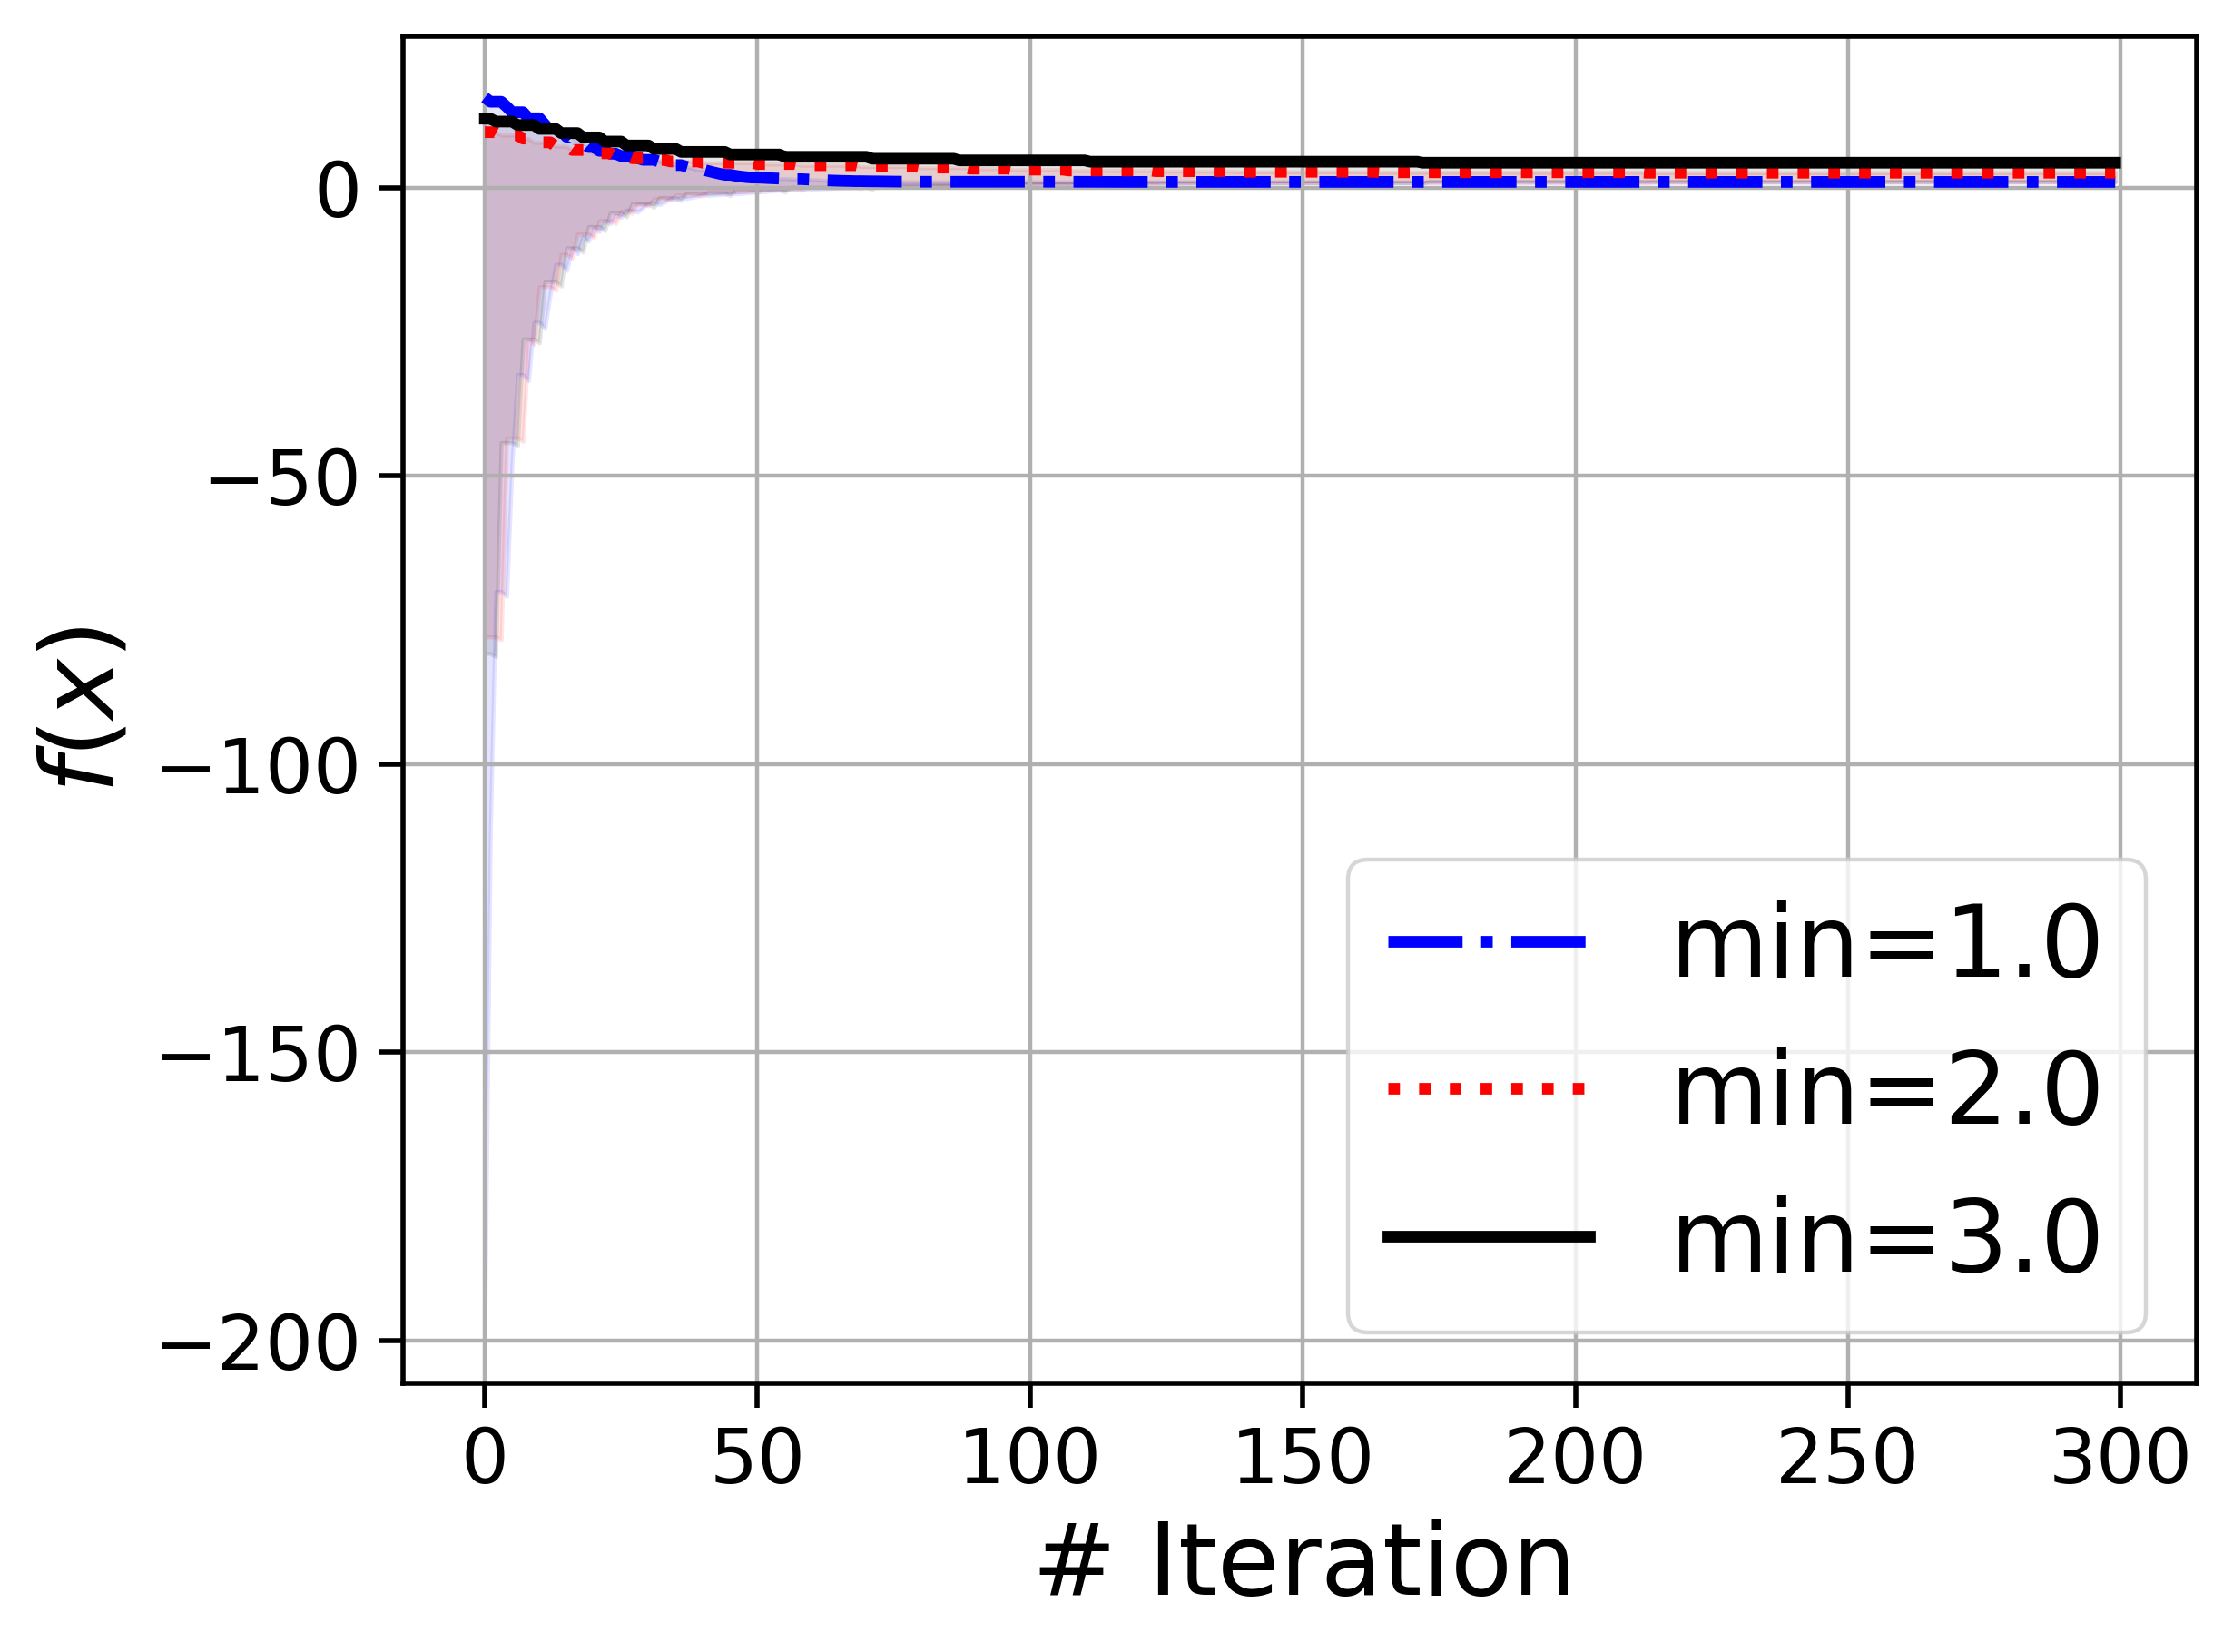

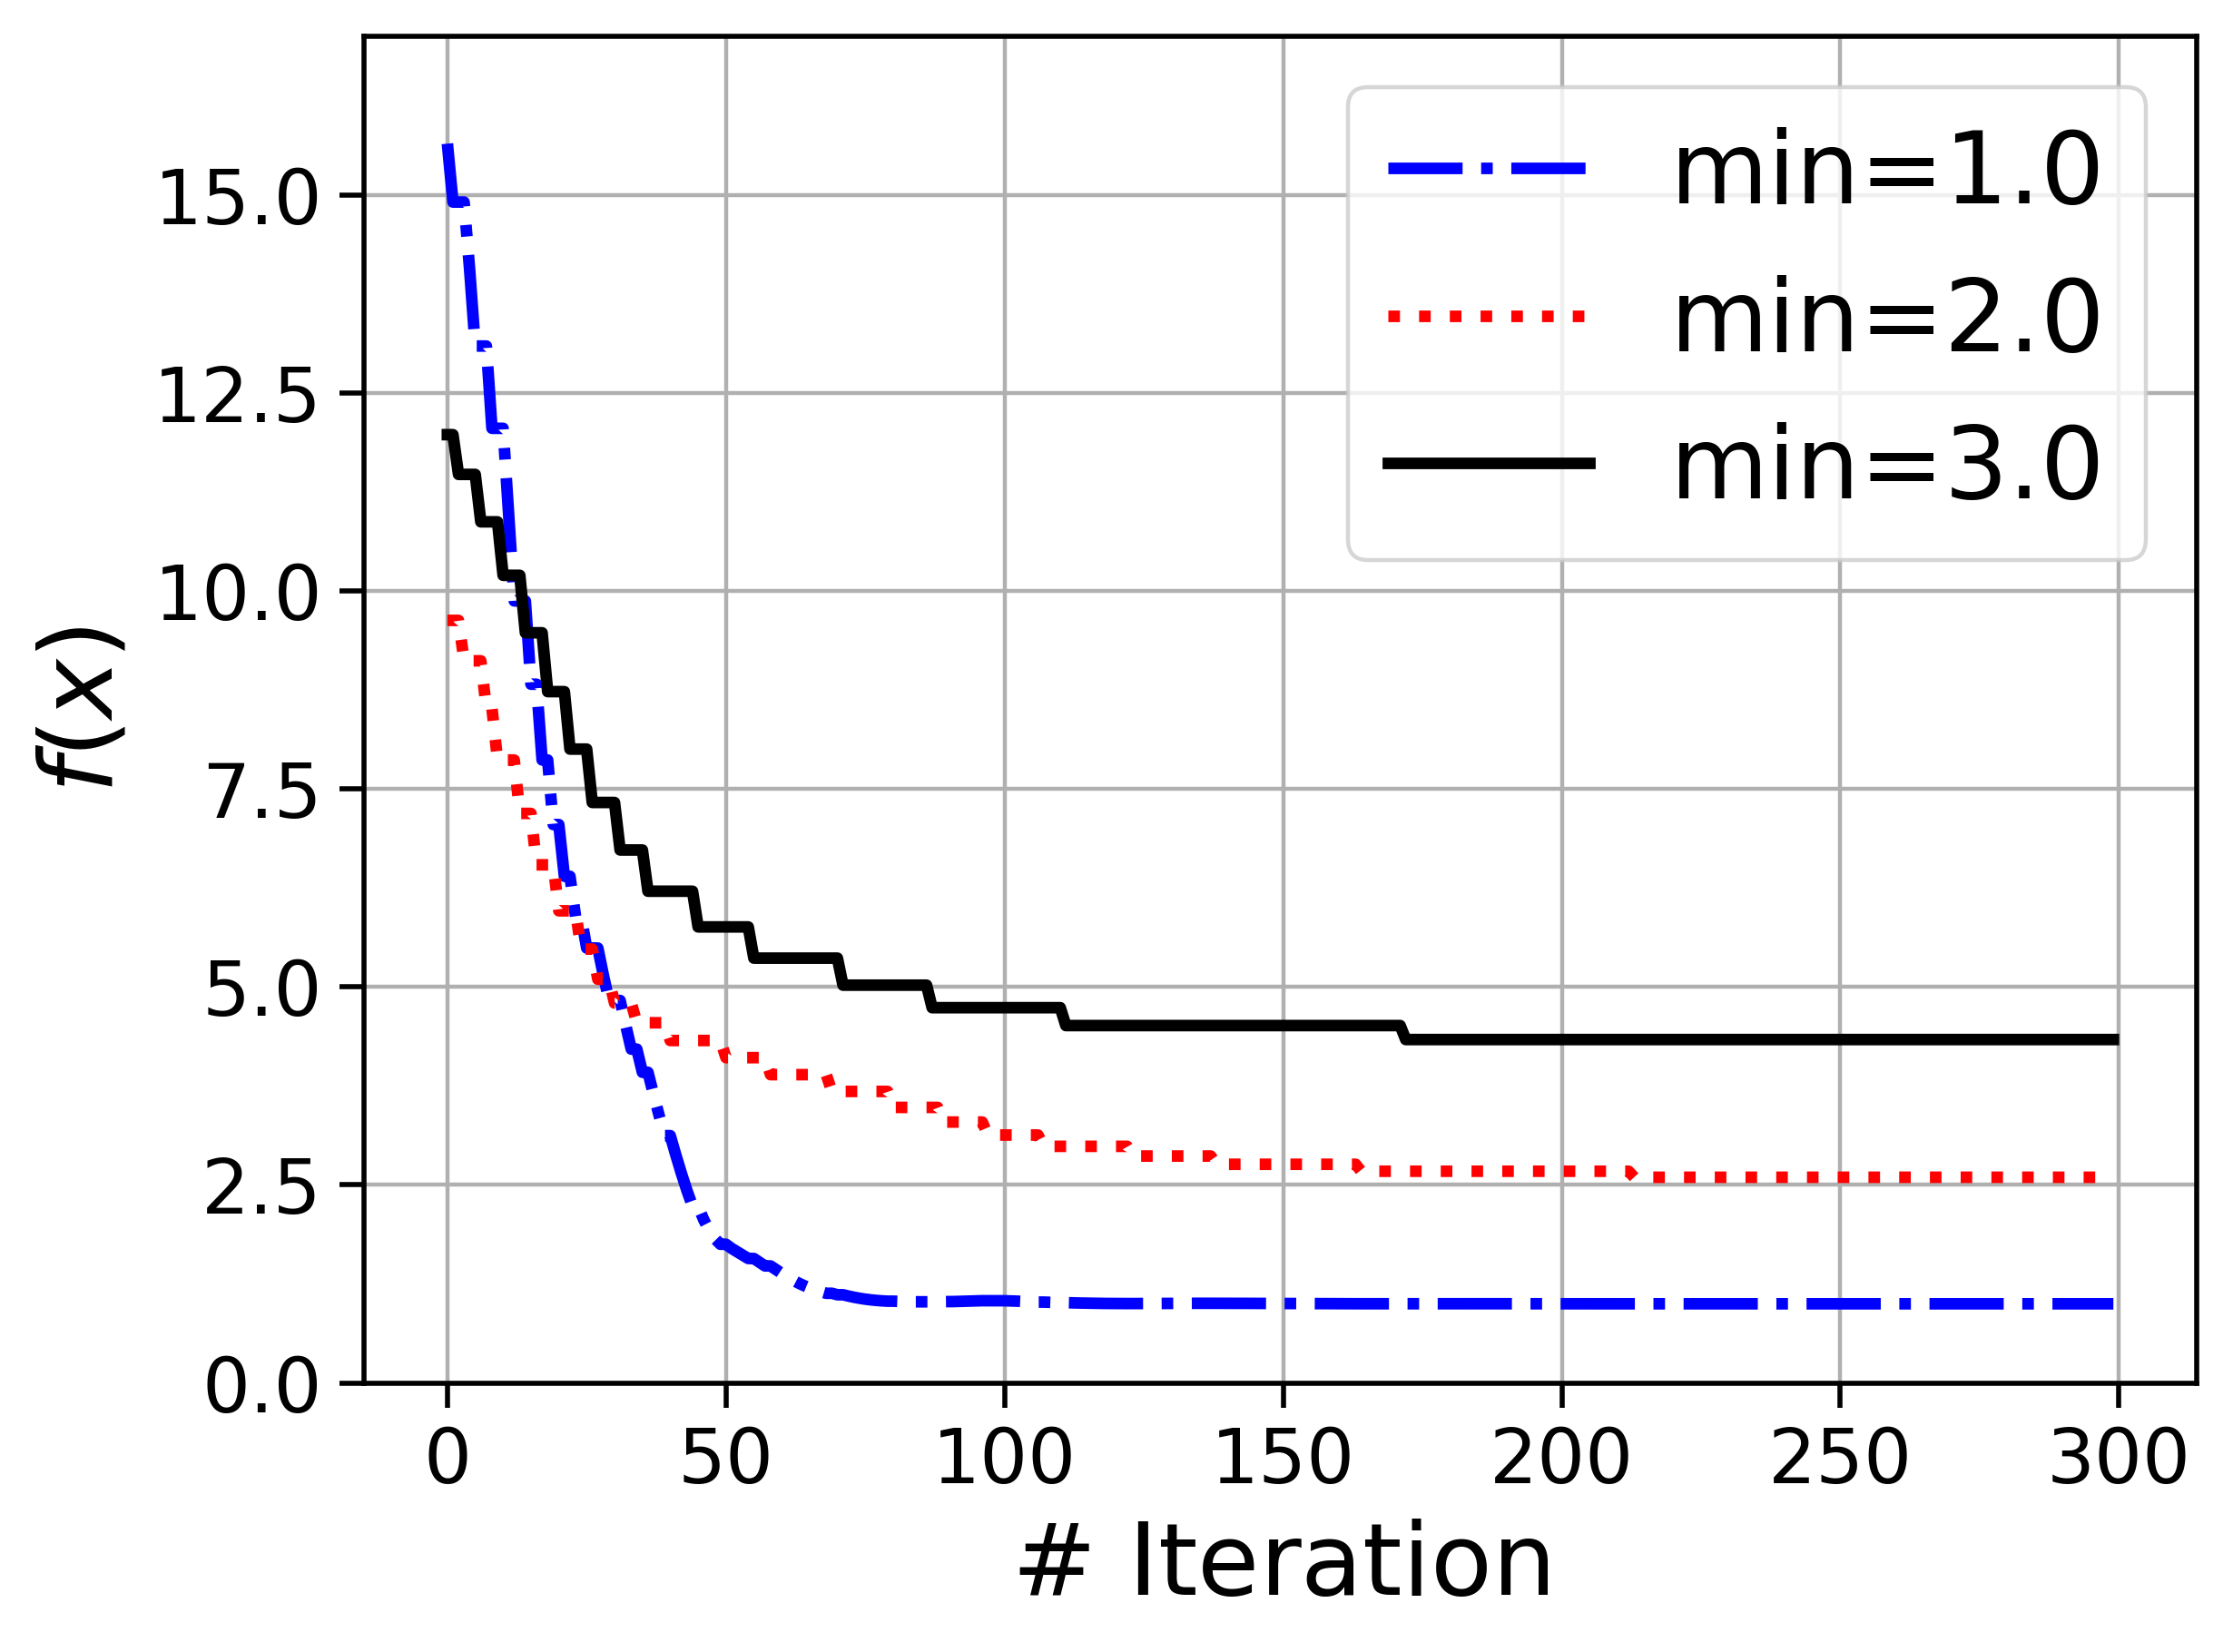

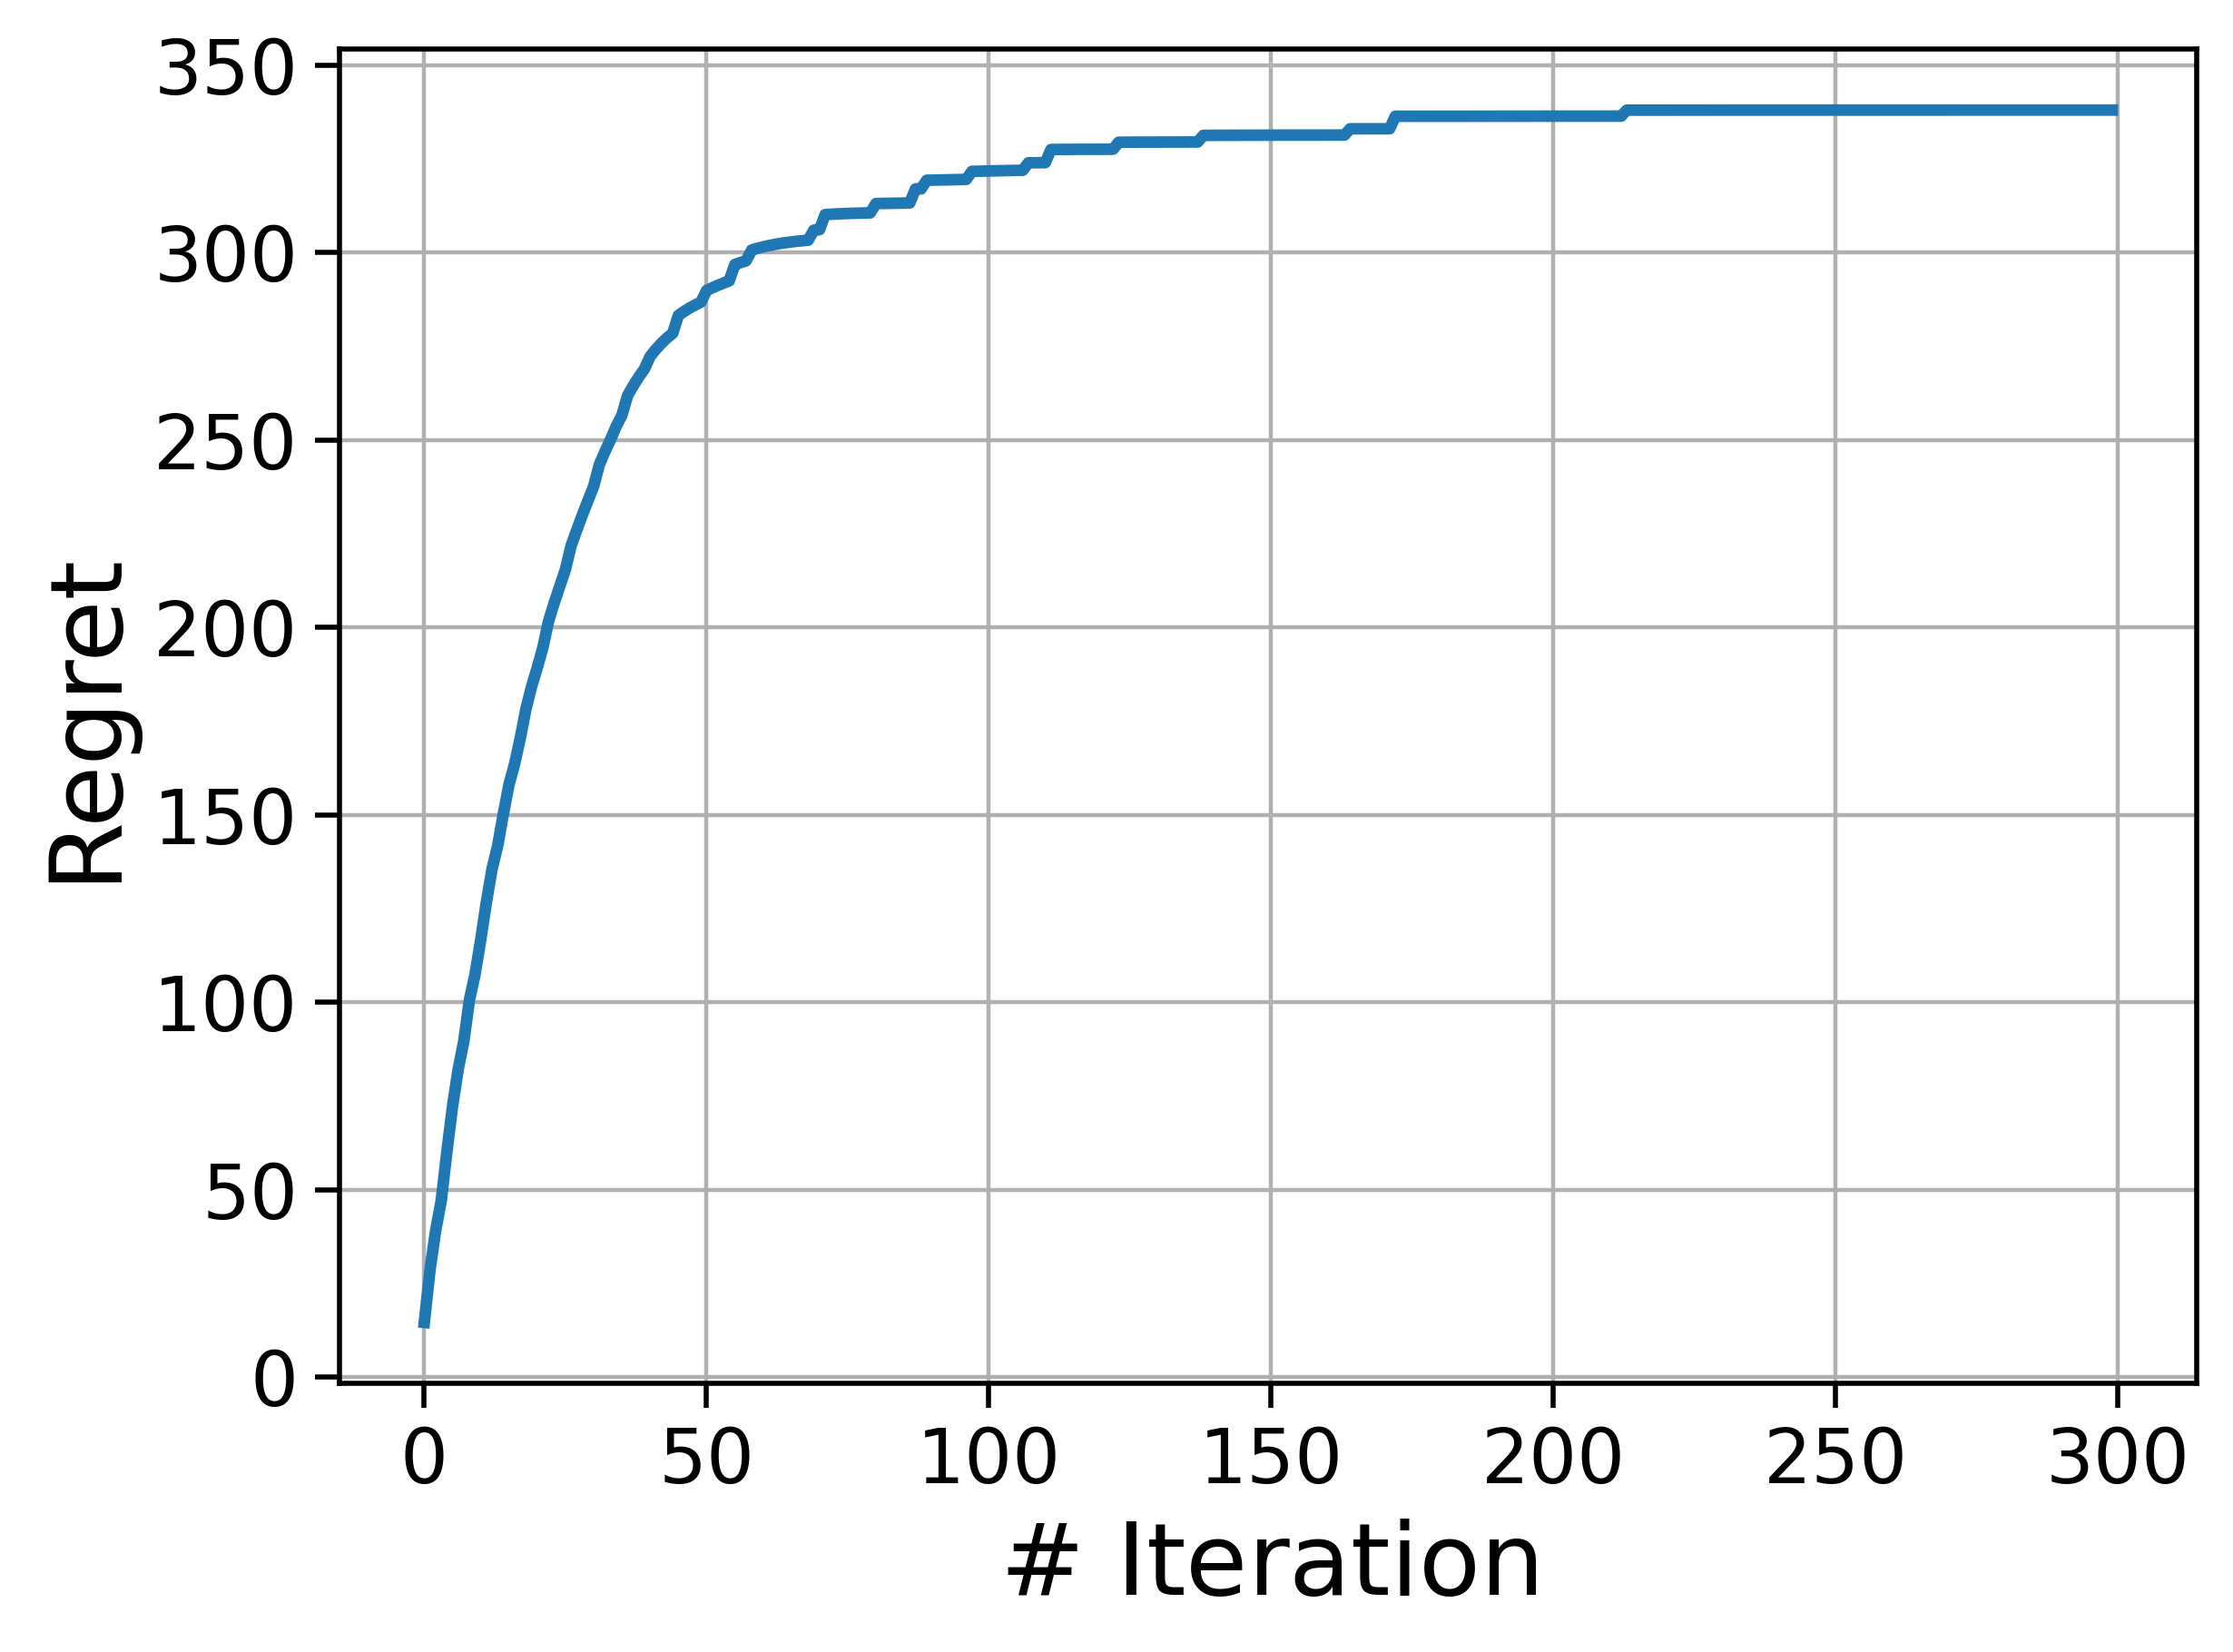

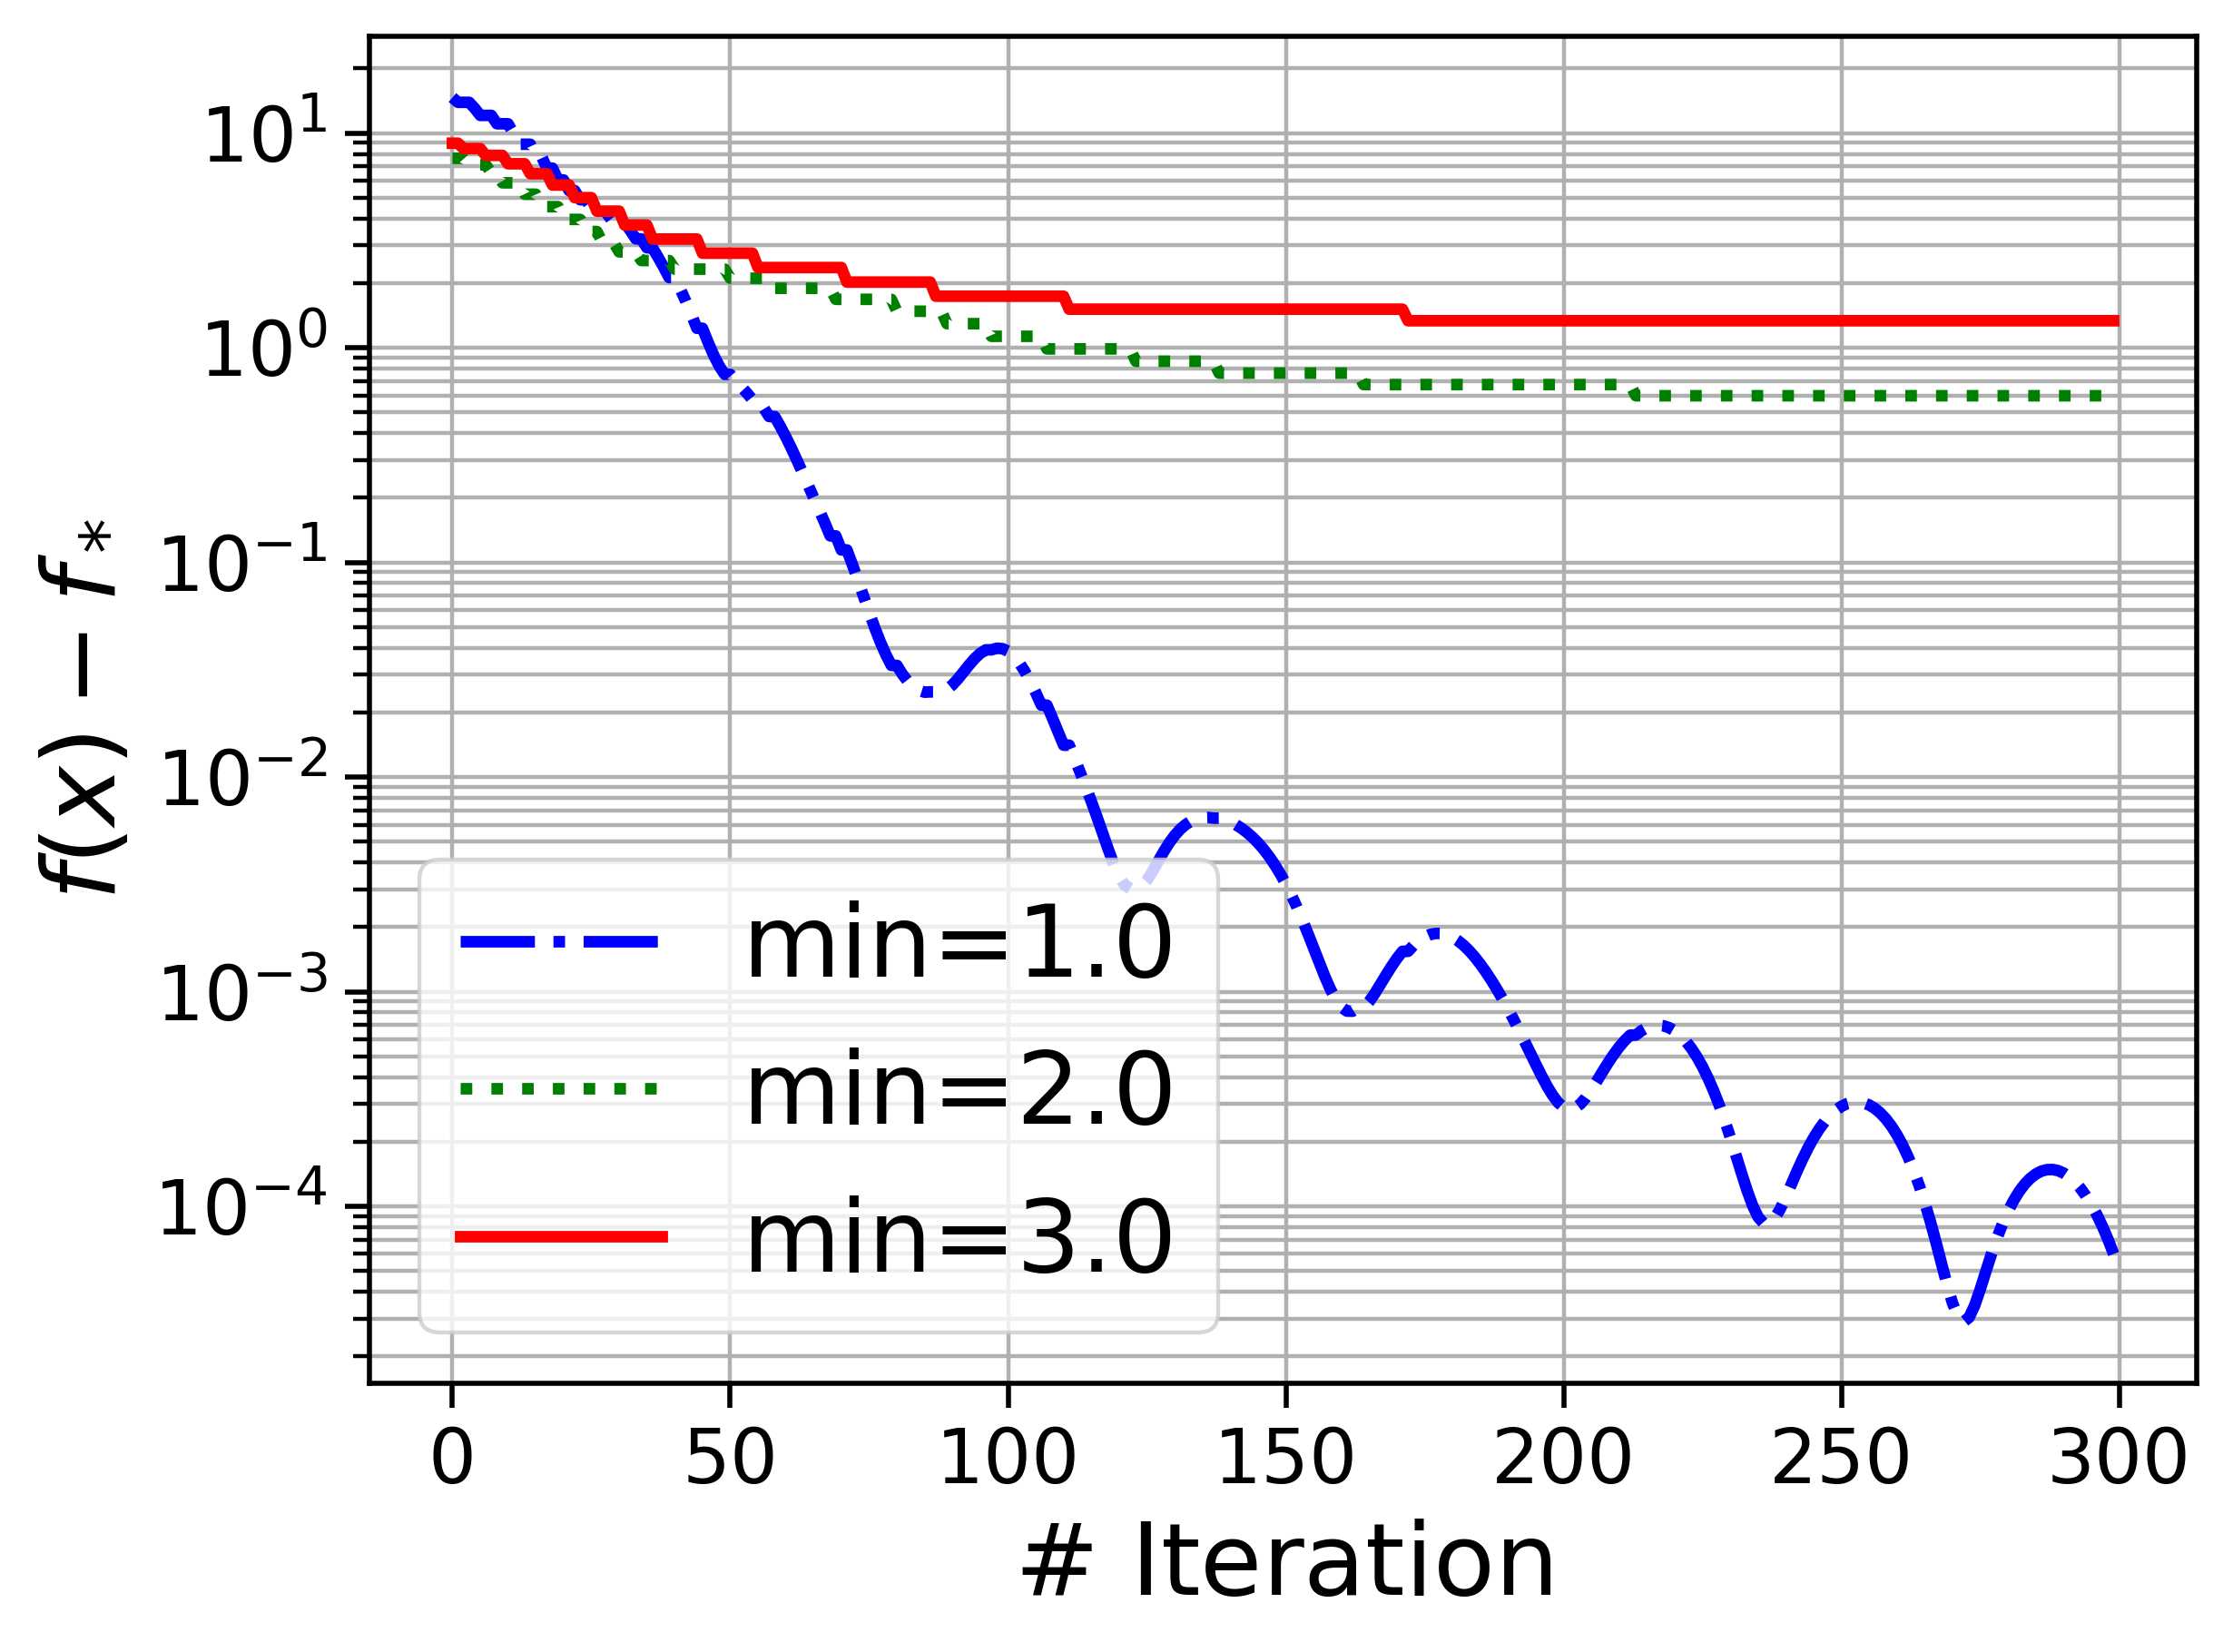

In [67]:
figs = {}
colors = ["b", "r", "black", "gray", "yellow"]
figs["running"] = alg_res.draw_all_steps(arms, colors=colors)
figs["running_clipped"] = alg_res.draw_all_steps(arms, colors=colors, ylim=[0, 17], with_intervals=False)
figs["cumulative"] = alg_res.draw_cumulative_regret(1)
figs["deltas"] = alg_res.draw_deltas(arms, min_vals)

In [68]:
import os


savepath = Path("../exp_results/figures")
# exp_results/figures
for f_name, fig in figs.items():
    path = savepath / "nonstochastic_smooth"
    if not path.exists():
        os.mkdir(path)
    f_name = f"{f_name}"
    savefig(fig, path, f_name)

## nonsmooth arms

In [76]:
from multiobjective_opt.synthetic_exp.functions import (
    ModularFunc,
    QuadFormSQRT,
)

def get_nonsmooth_arm(dim_nonsmooth, min_val=None, num_planes = 5, seed = 0):
    bounds = Bounds(-np.ones(dim_nonsmooth) * 1, np.ones(dim_nonsmooth) * 1)
    projection_function = Constraints(bounds=bounds)

    if min_val is None:
        min_val = np.random.randn()

    oracle_nonsmooth = JaxFunc(
        ModularFunc(
            dim_nonsmooth, optimization_set=bounds, min_val=min_val, num_planes=num_planes,
            seed = seed
        ),
        dim_nonsmooth,
    )
    x0 = np.zeros(dim_nonsmooth)
    L_nonsmooth, R = oracle_nonsmooth.func.get_params(x0)
    # G = 8 * dim_nonsmooth**0.5
    G = R * 2
    nonsmooth_optimizer = SGMTripleAveraging(
        oracle_nonsmooth,
        projection_function=projection_function,
        gamma=L_nonsmooth,
        L=L_nonsmooth,
        G=G,
        dimension=dim_nonsmooth,
    )
    
    nonsmooth_optimizer.name = f"min={min_val}"
    return nonsmooth_optimizer


In [103]:
def init_arms():
    dim = 20
    nonsmooth_arms = 3
    nonsmooth_arms_values = np.linspace(1, 3, num=nonsmooth_arms)
    num_planes_arm = [5, 10, 12]
    arms = []

    for i in range(nonsmooth_arms):
        nsm_opt = get_nonsmooth_arm(dim, 
                                nonsmooth_arms_values[i],
                                num_planes = num_planes_arm[i], 
                                seed= int(nonsmooth_arms_values[i]) + int(num_planes_arm[i]))
        arms.append(nsm_opt)
    return arms, nonsmooth_arms_values


arms, min_vals = init_arms()
alg = UCB(arms)
alg_res = alg.run(T=1000)

-7.347721240693458
-4.950135467335637
-5.209571603251172


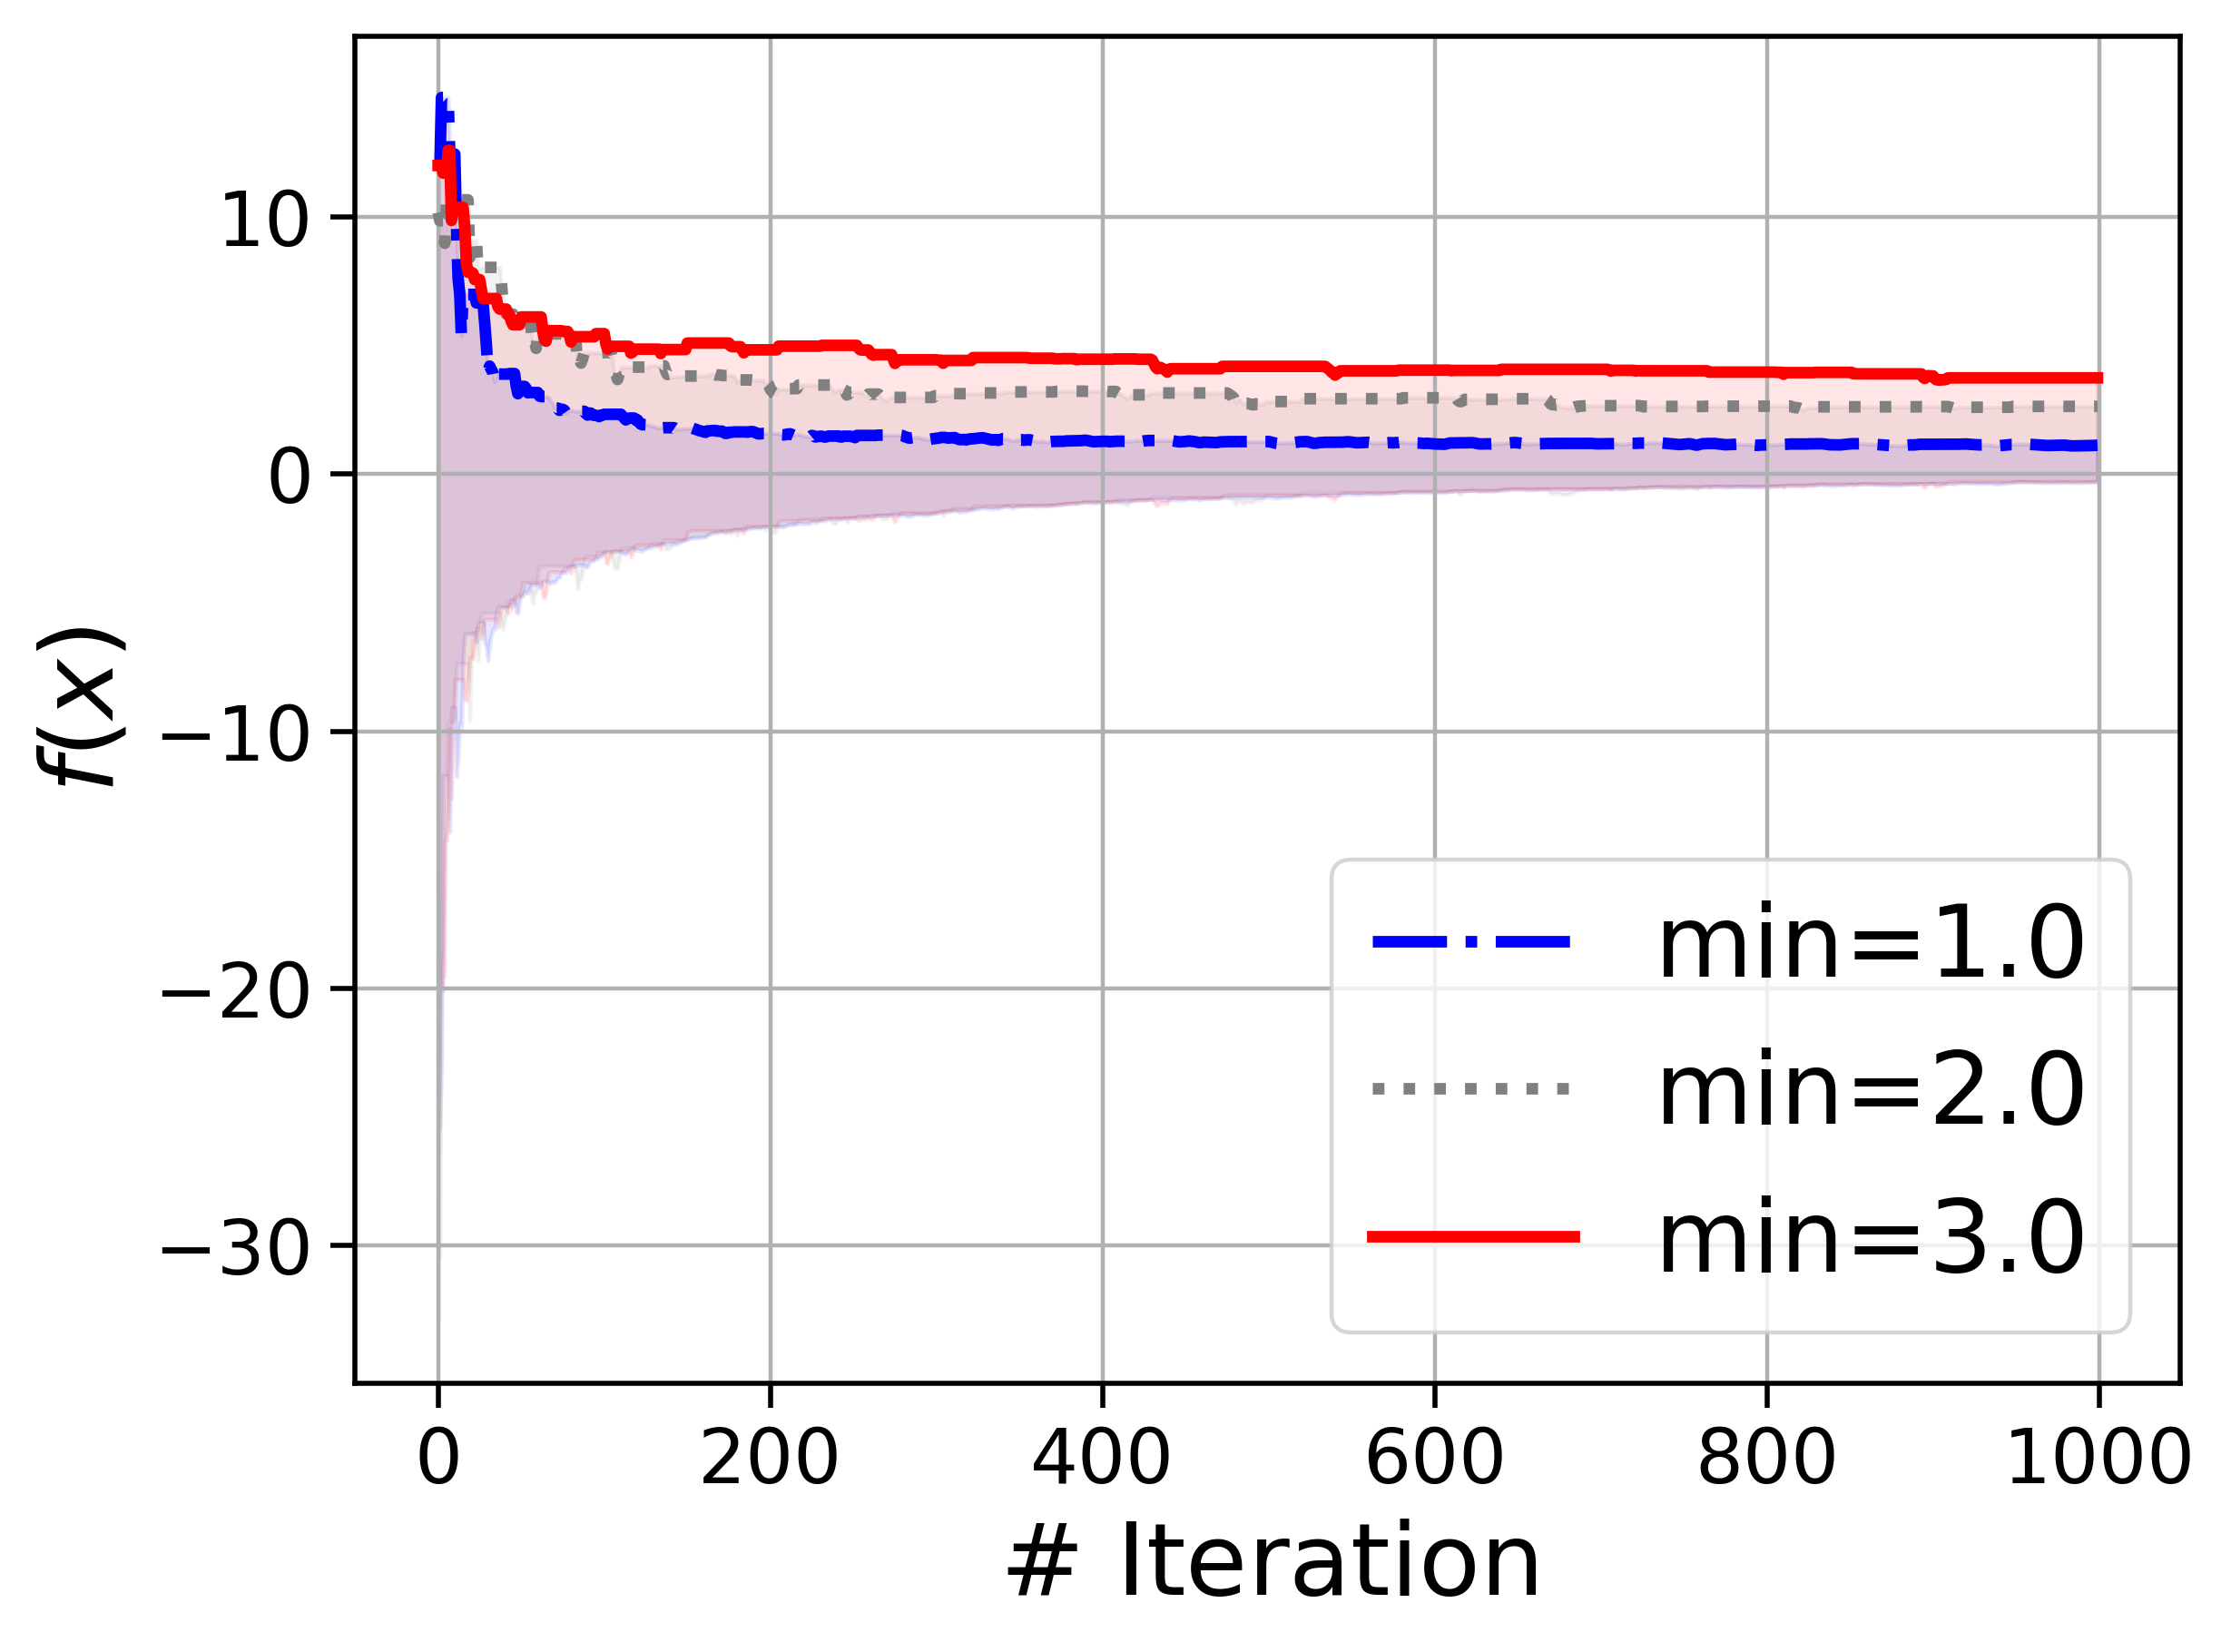

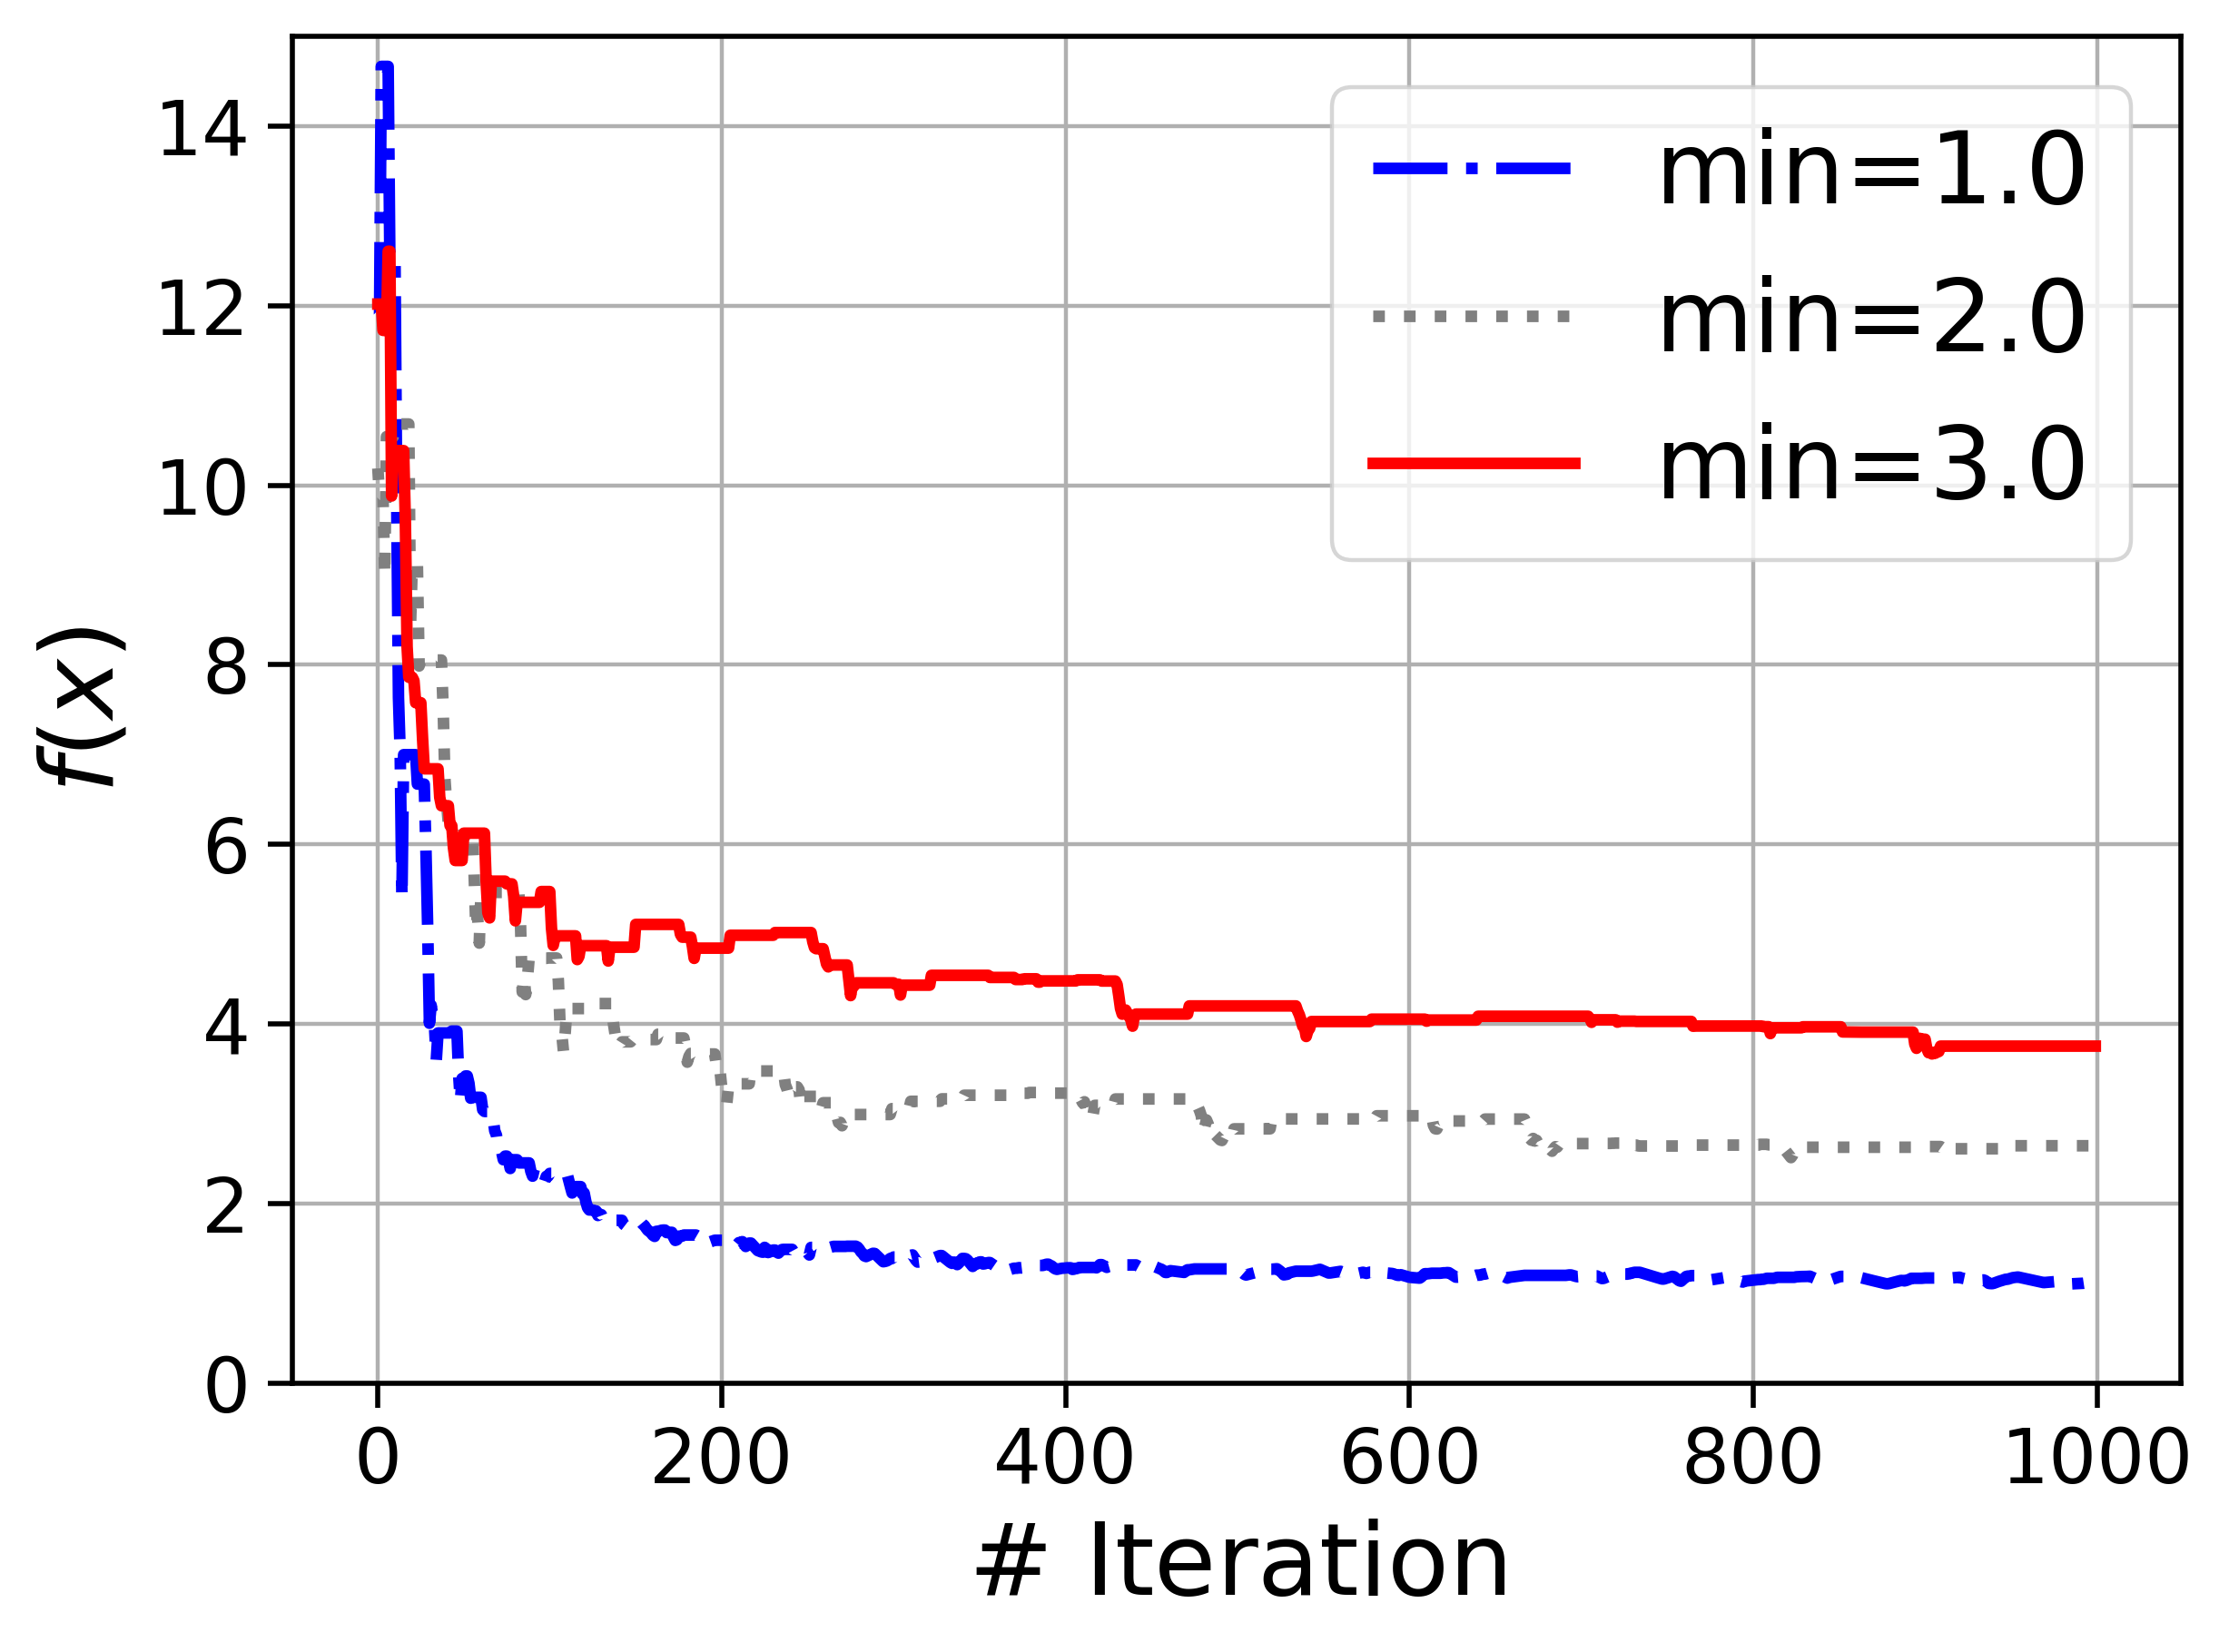

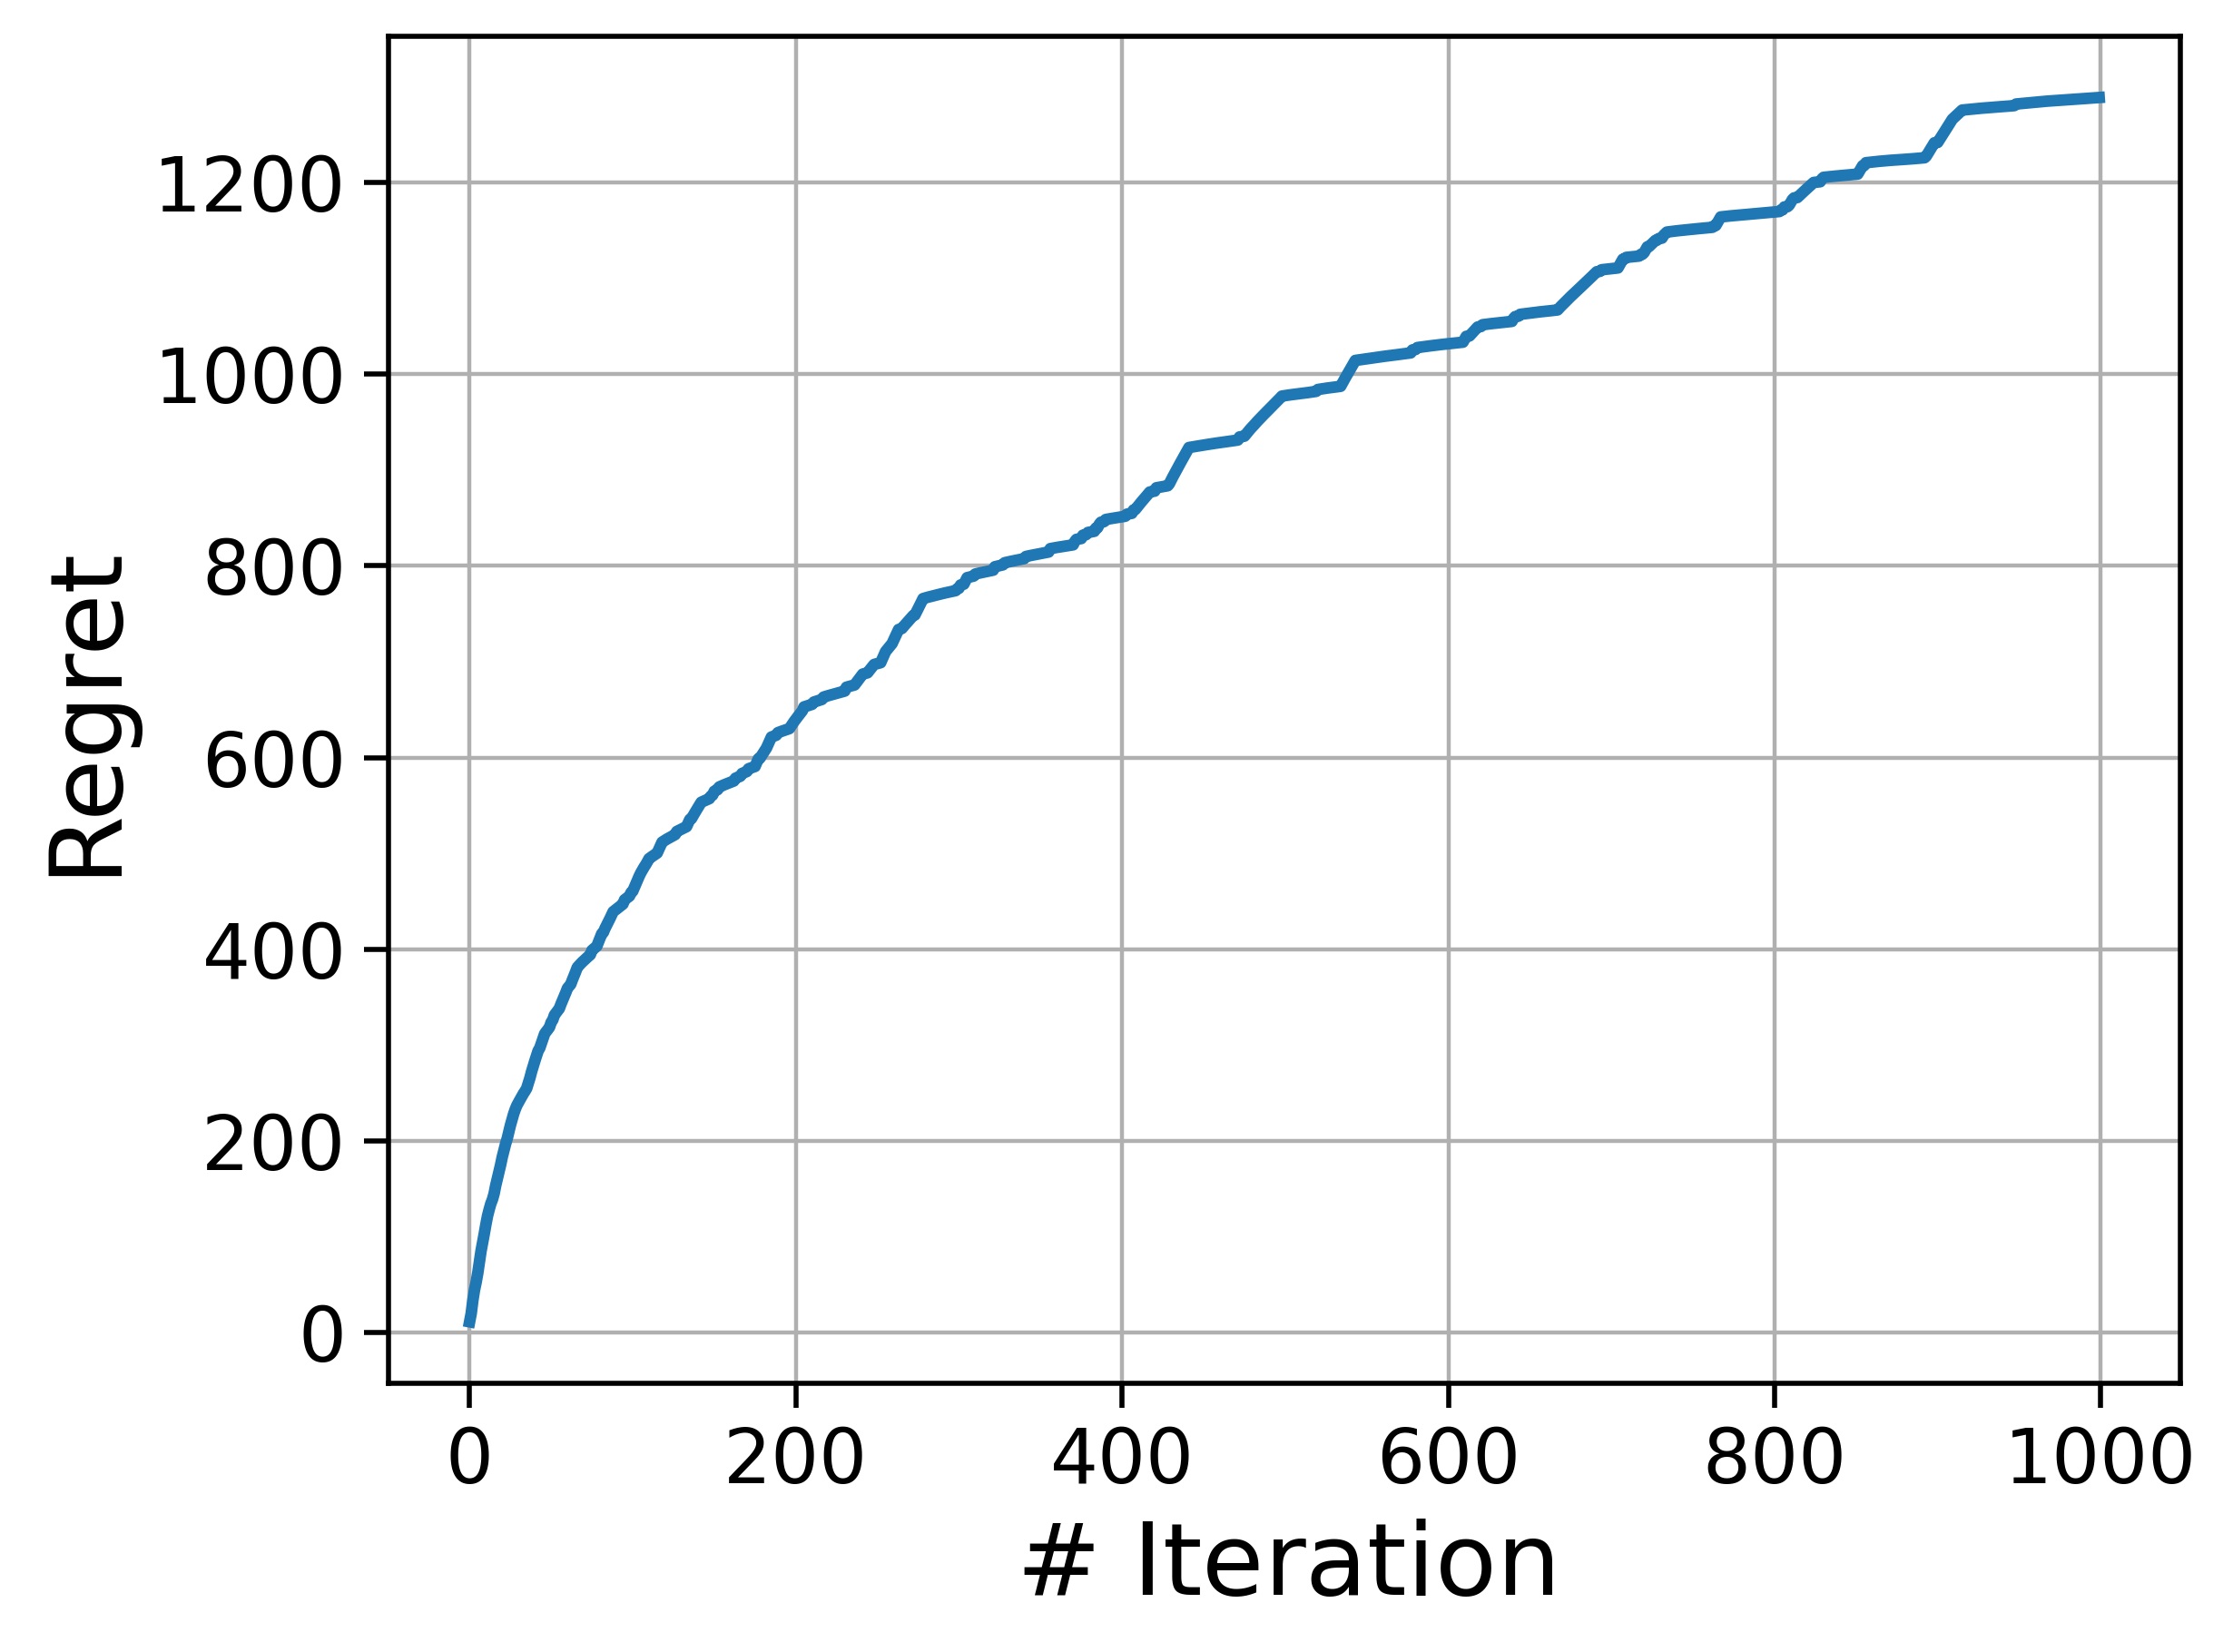

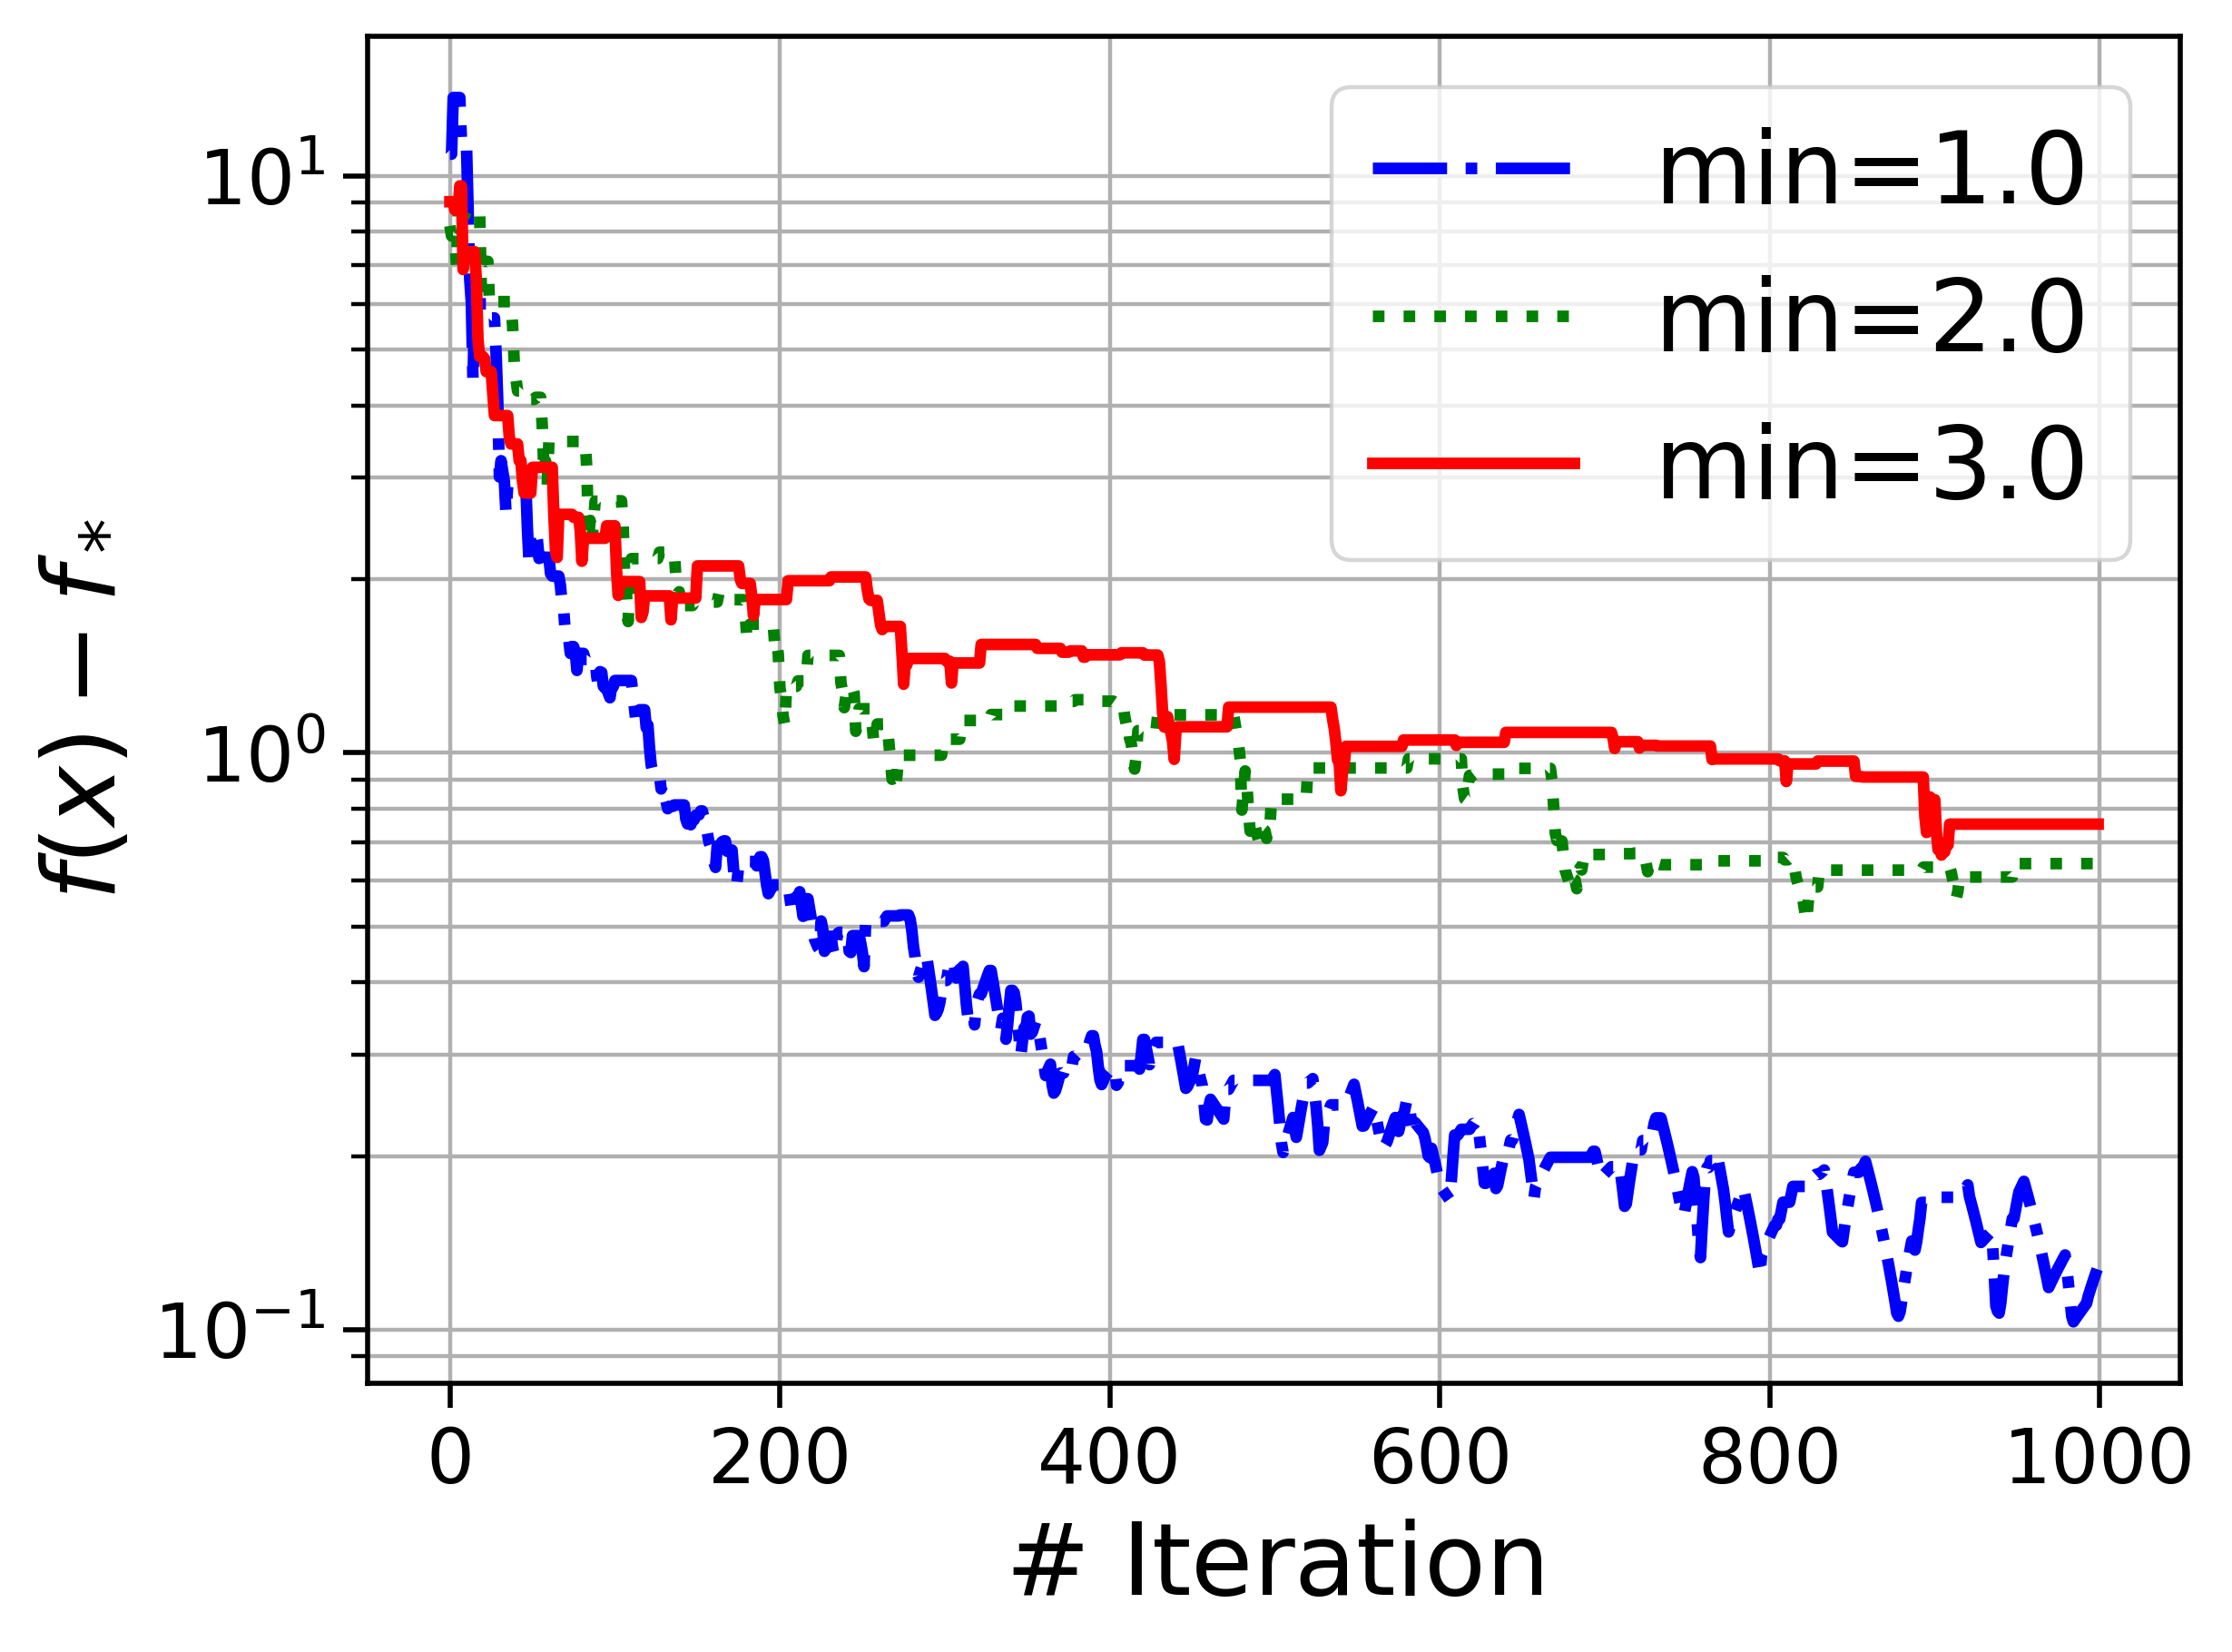

In [105]:
figs = {}
colors = ["b", "gray", "r", "black", "yellow"]
figs["running"] = alg_res.draw_all_steps(arms, colors=colors)
figs["running_clipped"] = alg_res.draw_all_steps(arms, colors=colors, ylim=[0, 15], with_intervals=False)
figs["cumulative"] = alg_res.draw_cumulative_regret(min(min_vals))
figs["deltas"] = alg_res.draw_deltas(arms, min_vals, ylim=(-0.5,))

In [106]:
import os


savepath = Path("../exp_results/figures")
# exp_results/figures
for f_name, fig in figs.items():
    path = savepath / "nonstochastic_nonsmooth"
    
    if not path.exists():
        os.mkdir(path)
    f_name = f"{f_name}"
    savefig(fig, path, f_name)

## stochastic arms

here consider multiple start, because this is a stochastic case

In [107]:
raise ValueError

ValueError: 

In [56]:
from multiobjective_opt.synthetic_exp.optimizers import StochasticAGD
from multiobjective_opt.synthetic_exp.function_handler import NormalRandomizer
from multiobjective_opt.synthetic_exp.functions import (
    ModularFunc,
    QuadFormSQRT,
)

def get_stochastic_arm(dim_smooth, min_val=None, sigma=1, seed = 0):
    if min_val is None:
        min_val = np.random.randn()

    bounds = Bounds(-np.ones(dim_smooth) * 7, np.ones(dim_smooth) * 7)
    projection_function = Constraints(bounds=bounds)

    grad_randomizer = NormalRandomizer(dim=dim_smooth, sigma=sigma)
    oracle_smooth = JaxFunc(
        # QuadFormNotStrongly(dim_smooth, min_val=min_val),
        QuadFormSQRT(dim_smooth, min_val=min_val, seed = seed, eigval_pow=1),
        dim_smooth,
        grad_randomizer=grad_randomizer,
    )
    k = 1
    x0 = None
    upper_bound  = 14 - min_val*2
    lower_bound = 12 - min_val*2

    assert upper_bound - lower_bound >= 1
    while True:
        x0 = np.ones(dim_smooth) * k + oracle_smooth.func.bias
        val = oracle_smooth.func(x0)
        if val > upper_bound:
            k /= 1.1
        elif val < lower_bound:
            k *= 1.2
        else:  
            # print(np.sum(np.abs(x0) > 5), np.max(np.abs(x0)))
            break
    
    Lipshitz, R = oracle_smooth.func.get_params(x0)
    L = Lipshitz
    D = R
    M = 2

    smooth_optimizer = StochasticAGD(
        oracle_smooth, projection=projection_function, x0=x0, sigma=sigma, L=L, D=D, M=M
    )
    smooth_optimizer.name = rf"min={min_val}" #, $\sigma=${sigma}"
    return smooth_optimizer


def init_arms():
    dim = 20
    nonsmooth_arms = 3

    nonsmooth_arms_values = np.array([1,2,3])
    sigmas = np.array([2, 2, 2])

    arms = []

    for i in range(nonsmooth_arms):
        seed = int(nonsmooth_arms_values[i] *2 +  17 * sigmas[i])
        nsm_opt = get_stochastic_arm(dim, nonsmooth_arms_values[i], sigma=sigmas[i], seed = seed)
        arms.append(nsm_opt)

    return arms,nonsmooth_arms_values

In [68]:

from joblib import Parallel, delayed

num_runs = 20
arms, min_vals = init_arms()

def run_alg():
    arms, min_vals = init_arms()
    alg = UCB(arms)
    print("run")
    alg_res = alg.run(T=1500)
    return alg_res
del_run = delayed(run_alg)
results = Parallel(20)(del_run() for _ in range(num_runs))

run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run
run


In [41]:
import matplotlib.pyplot as plt
from multiobjective_opt.utils import get_fig_set_style

LINESTYLES = [
    ("d", "dashdot"),
    ("d", "dotted"),
    ("d", "solid"),
    ("d", "dashed"),
    ("dashed", (0, (5, 5))),
]

def draw_cumulative_regret(results, min_val=0, tight_layout=True):
    rew_hist = np.stack([np.array(r.reward_history) for r in results], 0)
    rew_hist = np.cumsum(rew_hist - min_val, 1)
    rew_mean = rew_hist.mean(0)
    rew_high = np.quantile(rew_hist, 0.95, 0)
    rew_low = np.quantile(rew_hist, 0.05, 0)
    # rew_std = rew_hist.std(0)
    # cumulative_regret = np.cumsum(rew_hist - min_val)
    fig, ax, _ = get_fig_set_style(len(min_vals))
    x = np.arange(rew_mean.shape[0])
    ax.plot(rew_mean)
    ax.fill_between(x, rew_low, rew_high, alpha=0.2,)

    ax.set_xlabel(r"$\#$ Iteration")
    ax.set_ylabel(r"Regret")
    # ax.grid()
    if tight_layout:
        fig.tight_layout()
    return fig



def draw_all_steps(
    results,
    arms,
    colors=None,
    with_intervals=True,
    xlim=None,
    ylim=None,
    tight_layout=True,
):
    fig, ax, _ = get_fig_set_style(len(arms))
    if colors is None:
        colors = ["b", "g", "r", "black"]
    assert len(colors) >= len(arms)
    values_stacked = np.stack([r.values_history for r in results], 0)
    values_mean = values_stacked.mean(0)
    # values_std = values_stacked.std(0)
    rew_high = np.quantile(values_stacked, 0.95, 0)
    rew_low = np.quantile(values_stacked, 0.05, 0)

    for arm, v_mean, v_low, v_high, color, ls in zip(
        arms, values_mean, rew_low, rew_high, colors, LINESTYLES
    ):
        a_n = arm.name
        x = np.arange(len(v_mean))
        ax.plot(x, v_mean, label=a_n, color=color, linestyle = ls[1])
        if with_intervals:
            ax.fill_between(
                x,
                y1=v_low,
                y2=v_high,
                color=color,
                alpha=0.1,
            )

    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel(r"$\#$ Iteration")
    ax.set_ylabel(r"$f(x)$")
    plt.legend()
    # ax.grid()
    if tight_layout:
        fig.tight_layout()
    return fig

def draw_deltas(
        results,
        arms,
        min_values,
        colors=None,
        with_intervals=True,
        xlim=None,
        ylim=None,
        tight_layout=True,
    ):
        fig, ax, _ = get_fig_set_style(1)
        if colors is None:
            colors = ["b", "g", "r", "black"]

        values_stacked = np.stack([r.values_history for r in results], 0) - min_vals[None, :, None]
        values_mean = values_stacked.mean(0)
        # values_std = values_stacked.std(0)
        
        rew_high = np.quantile(values_stacked, 0.95, 0)
        rew_low = np.quantile(values_stacked, 0.05, 0)

        assert len(colors) >= len(arms)
        for arm, v_mean, v_low, v_high, color, min_val, ls in zip(
            arms, values_mean, rew_low, rew_high, colors, min_values, LINESTYLES
        ):
            a_n = arm.name
            x = np.arange(len(v_mean))
            ax.plot(x, v_mean, label=a_n, color=color, linestyle = ls[1])
            if with_intervals:
                ax.fill_between(
                    x,
                    y1=v_low,
                    y2=v_high,
                    color=color,
                    alpha=0.1,
                )

        ax.set_yscale("log")
        if xlim is not None:
            ax.set_xlim(*xlim)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid()
        ax.set_xlabel(r"$\#$ Iteration")
        ax.set_ylabel(r"$f(x) - f_*$")
        plt.legend()
        return fig


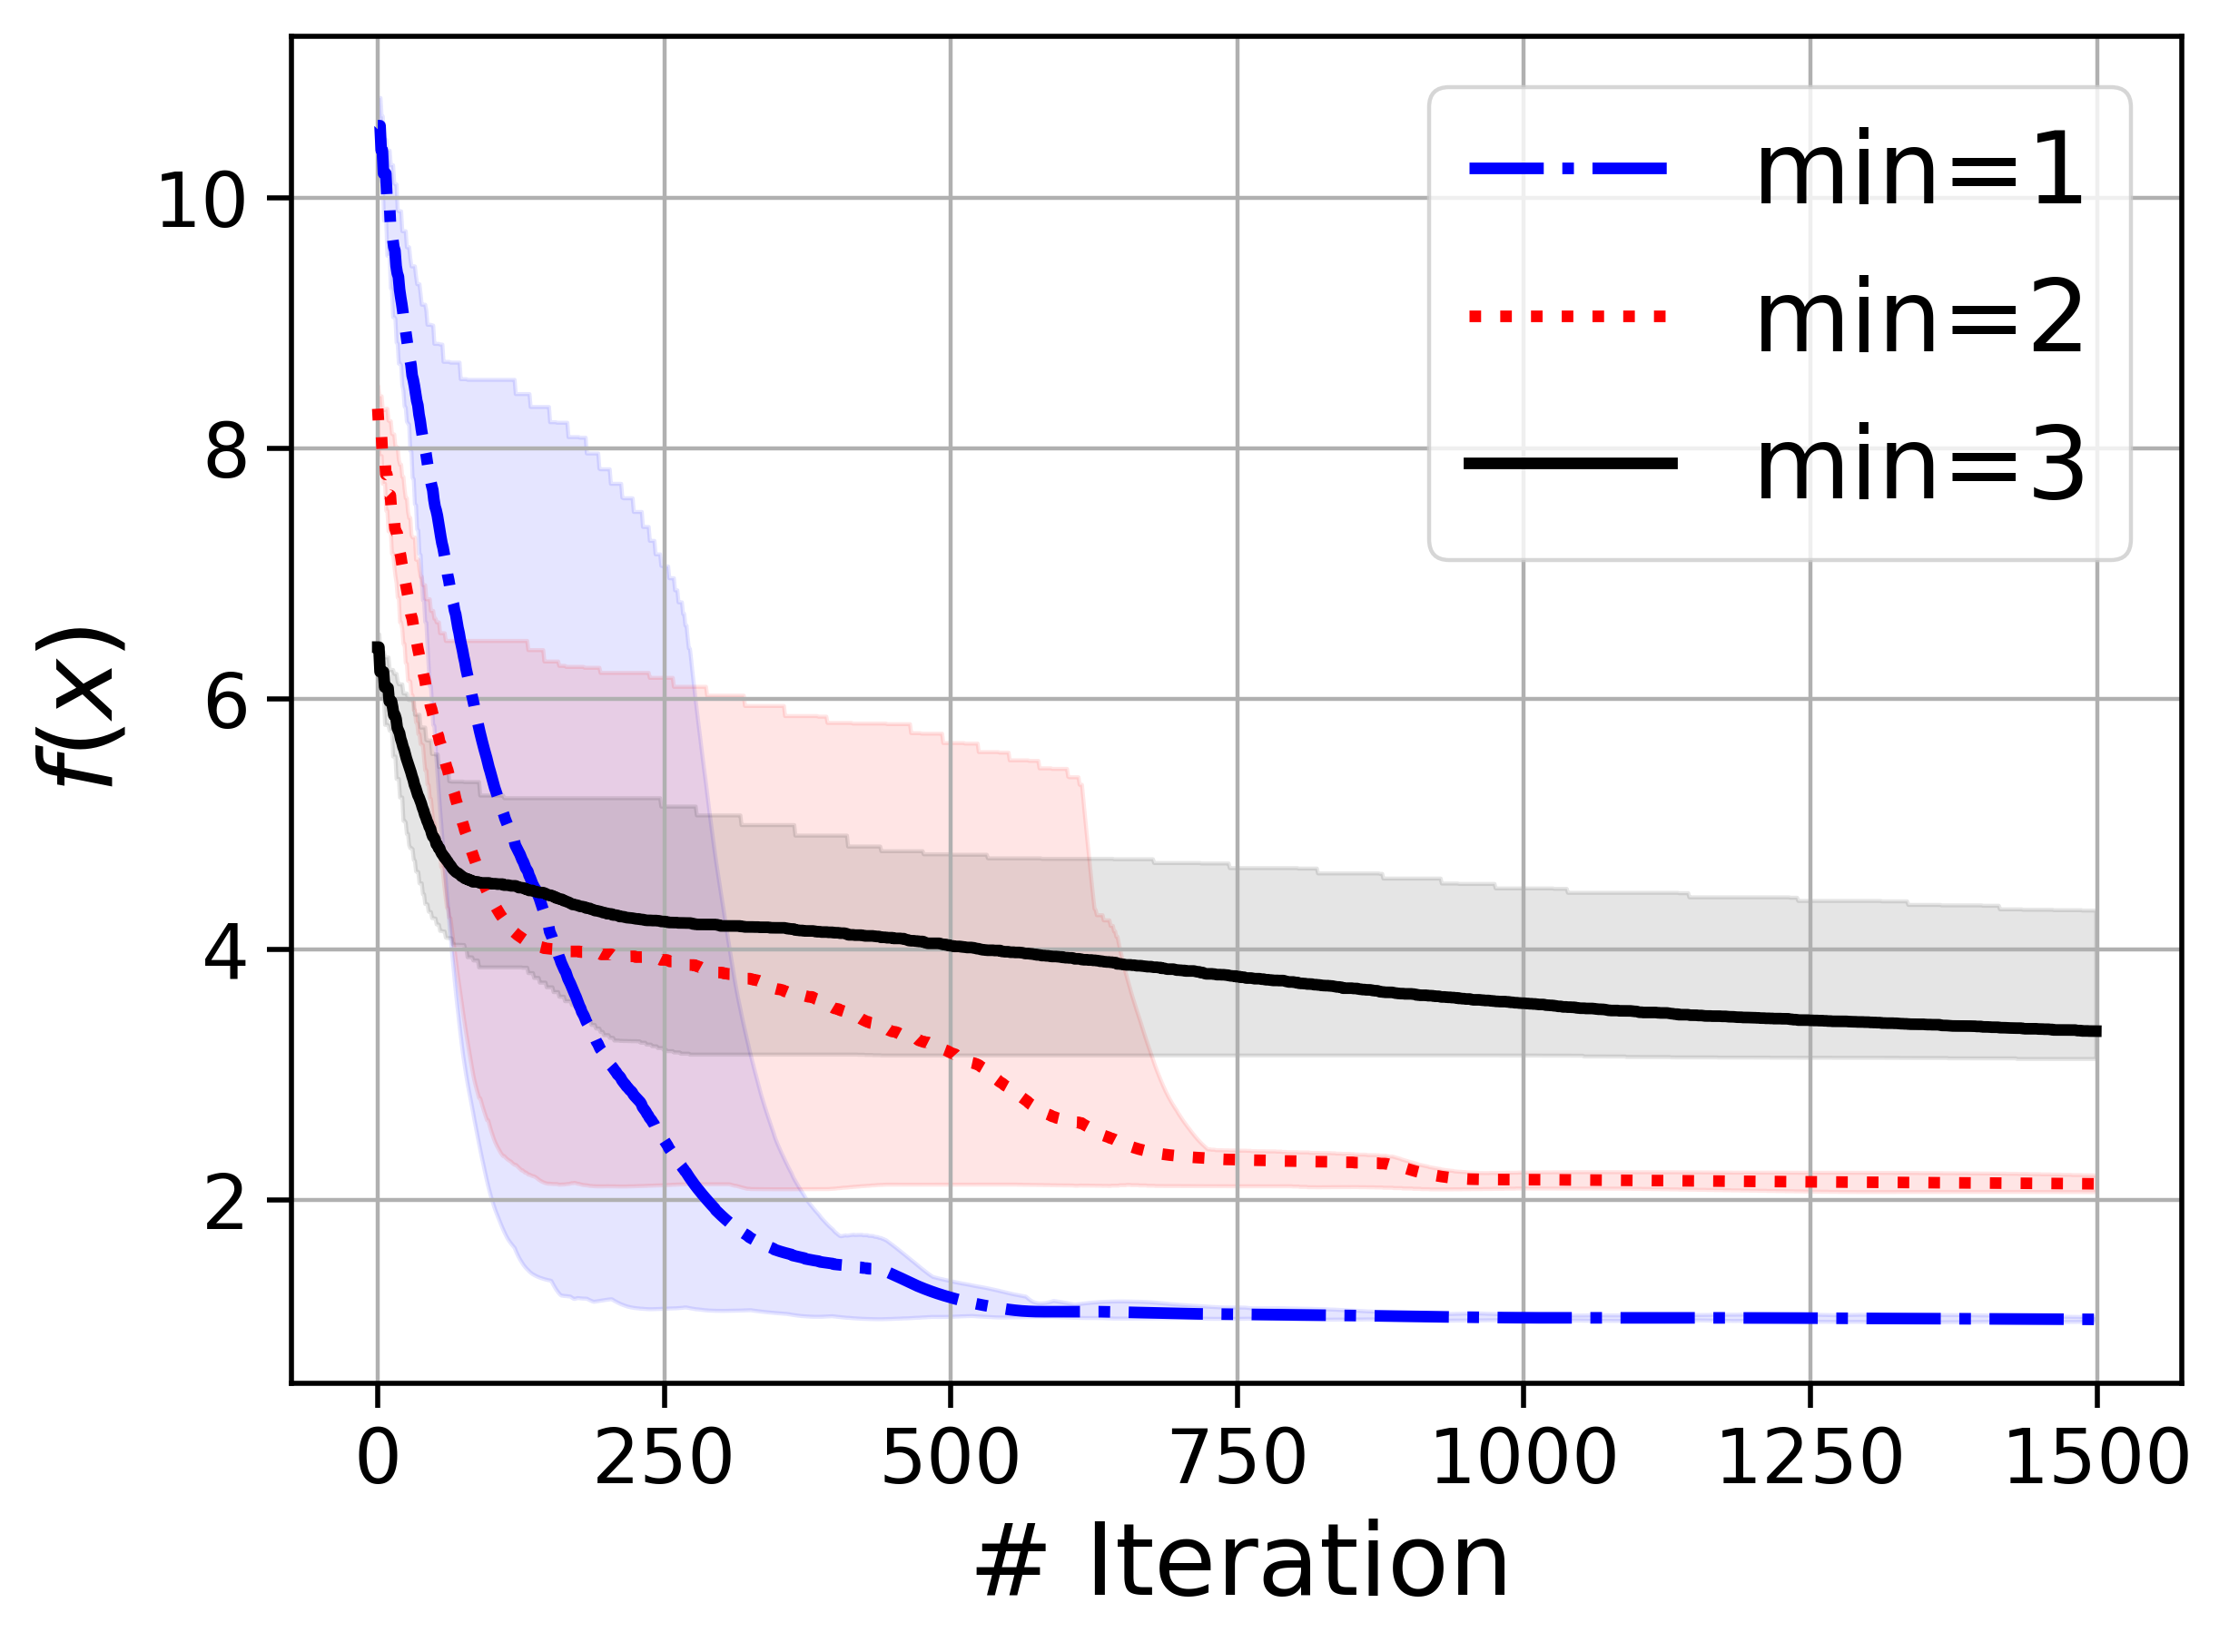

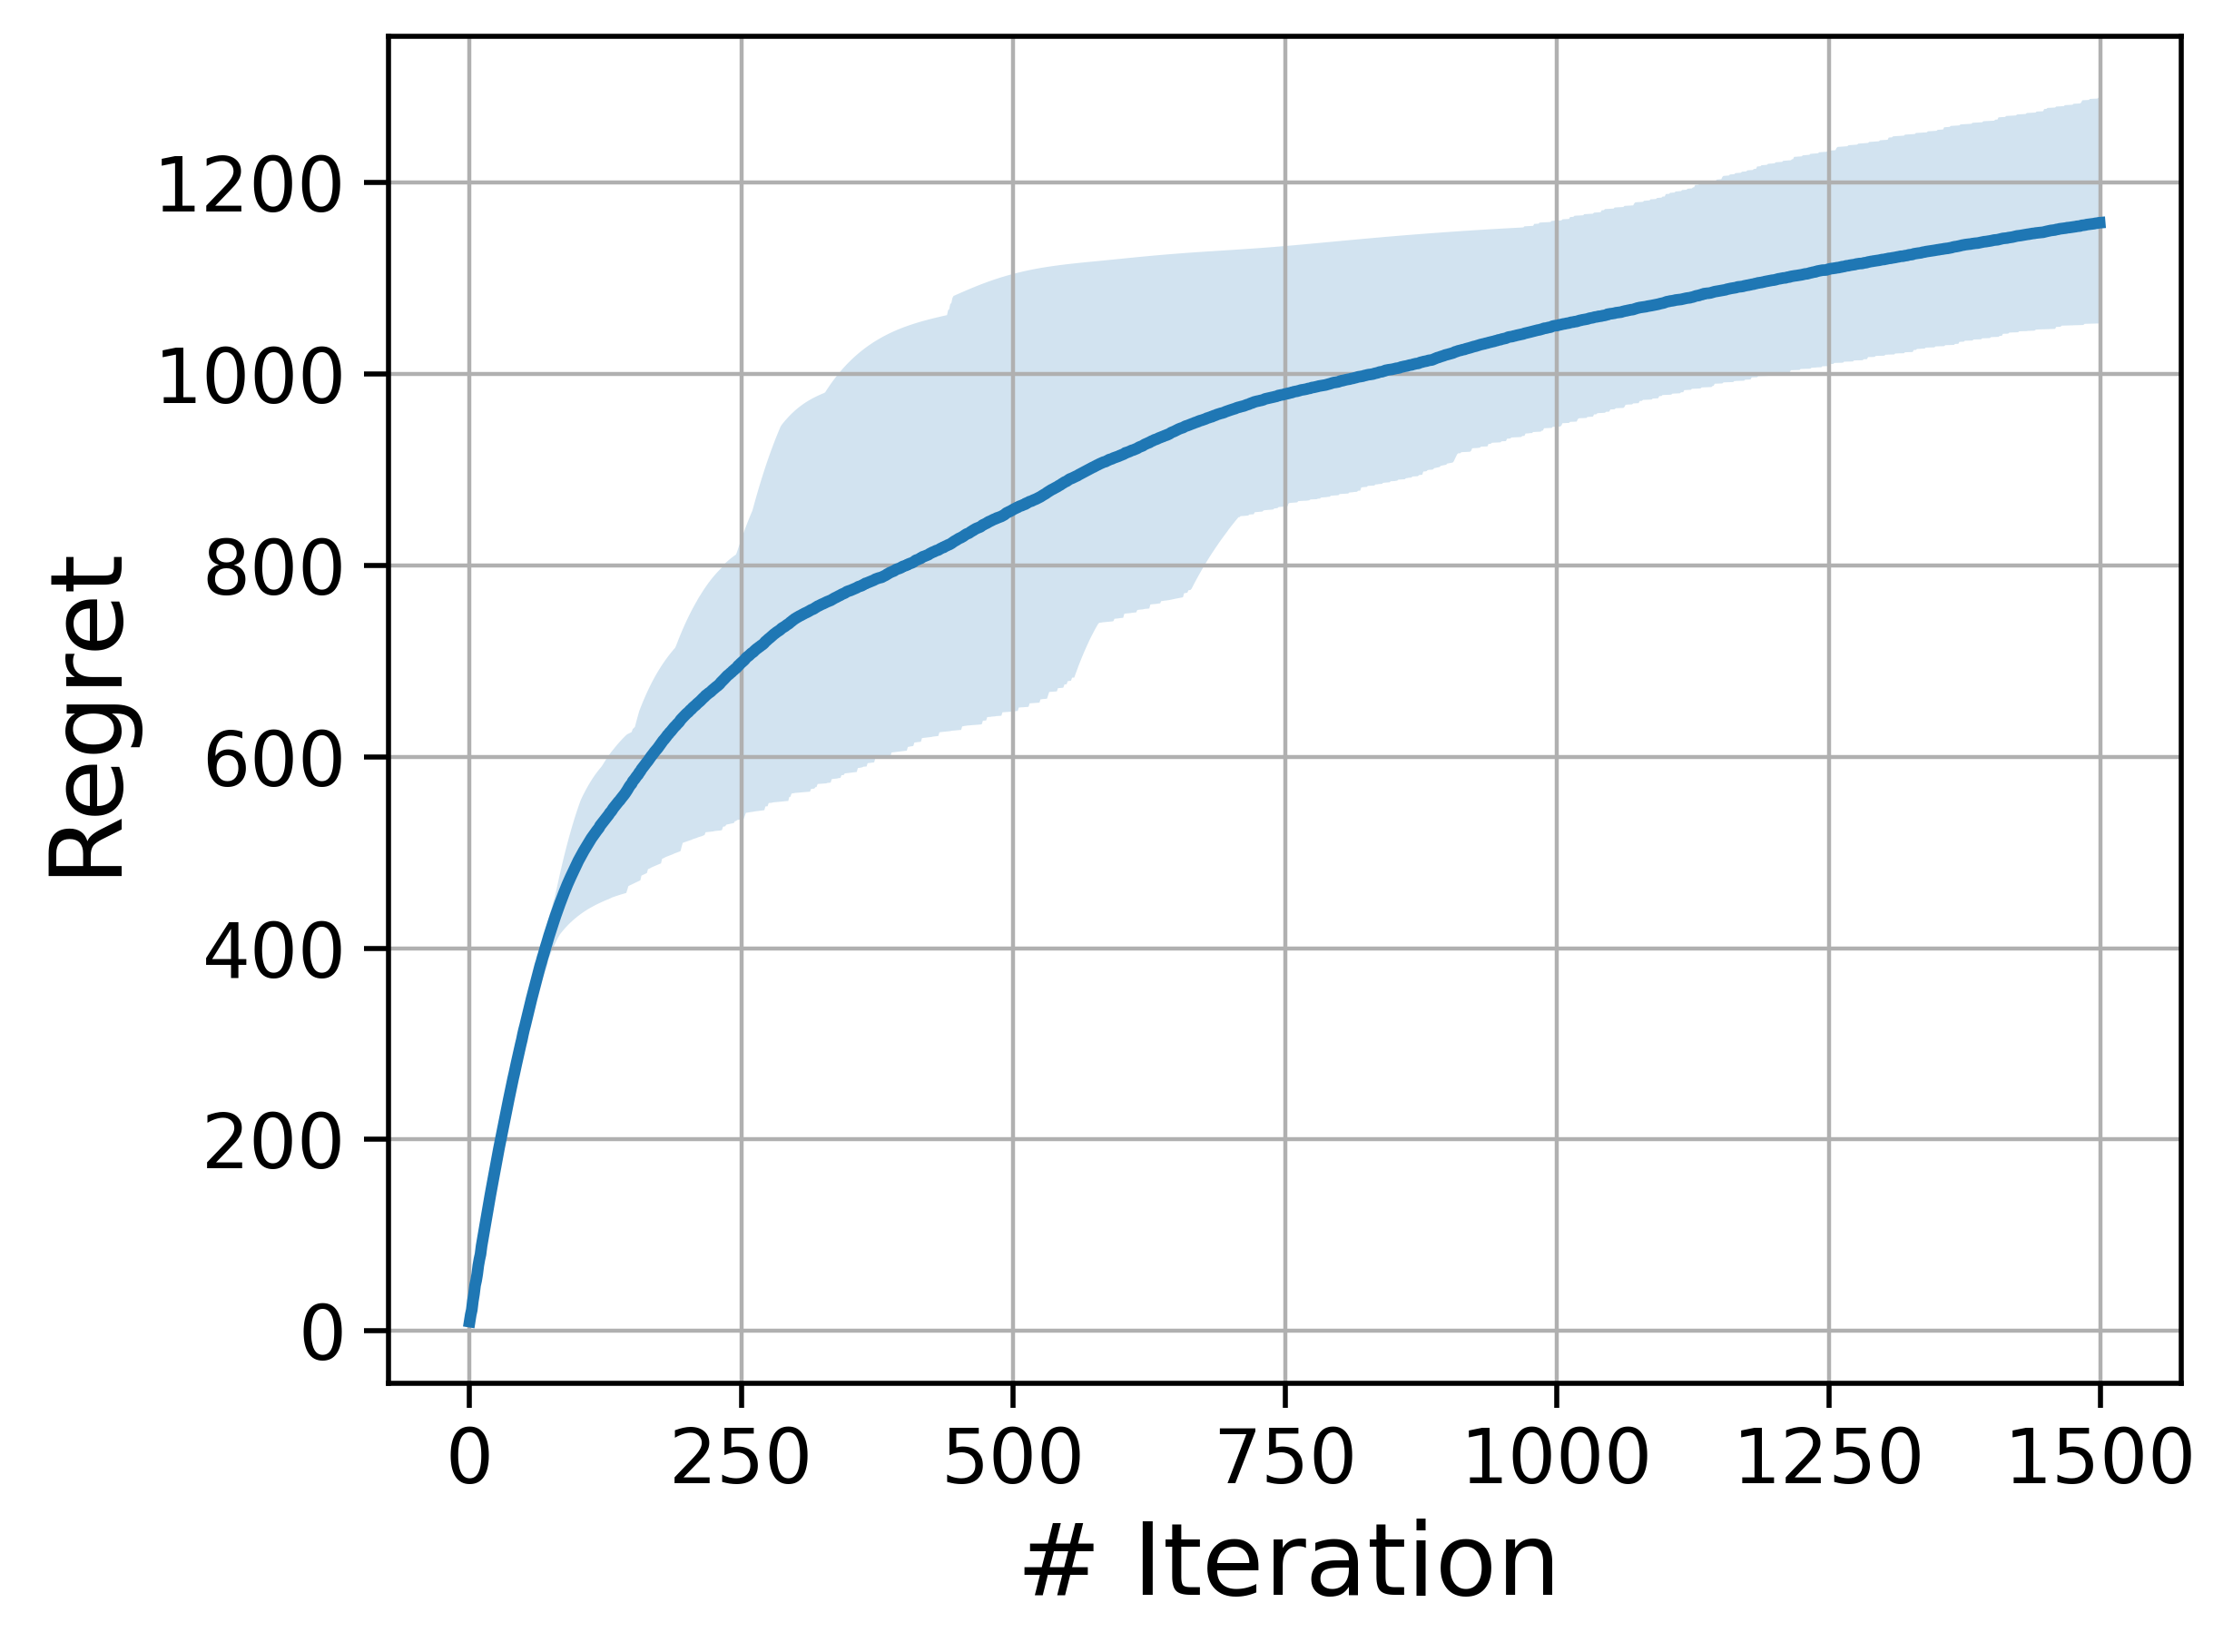

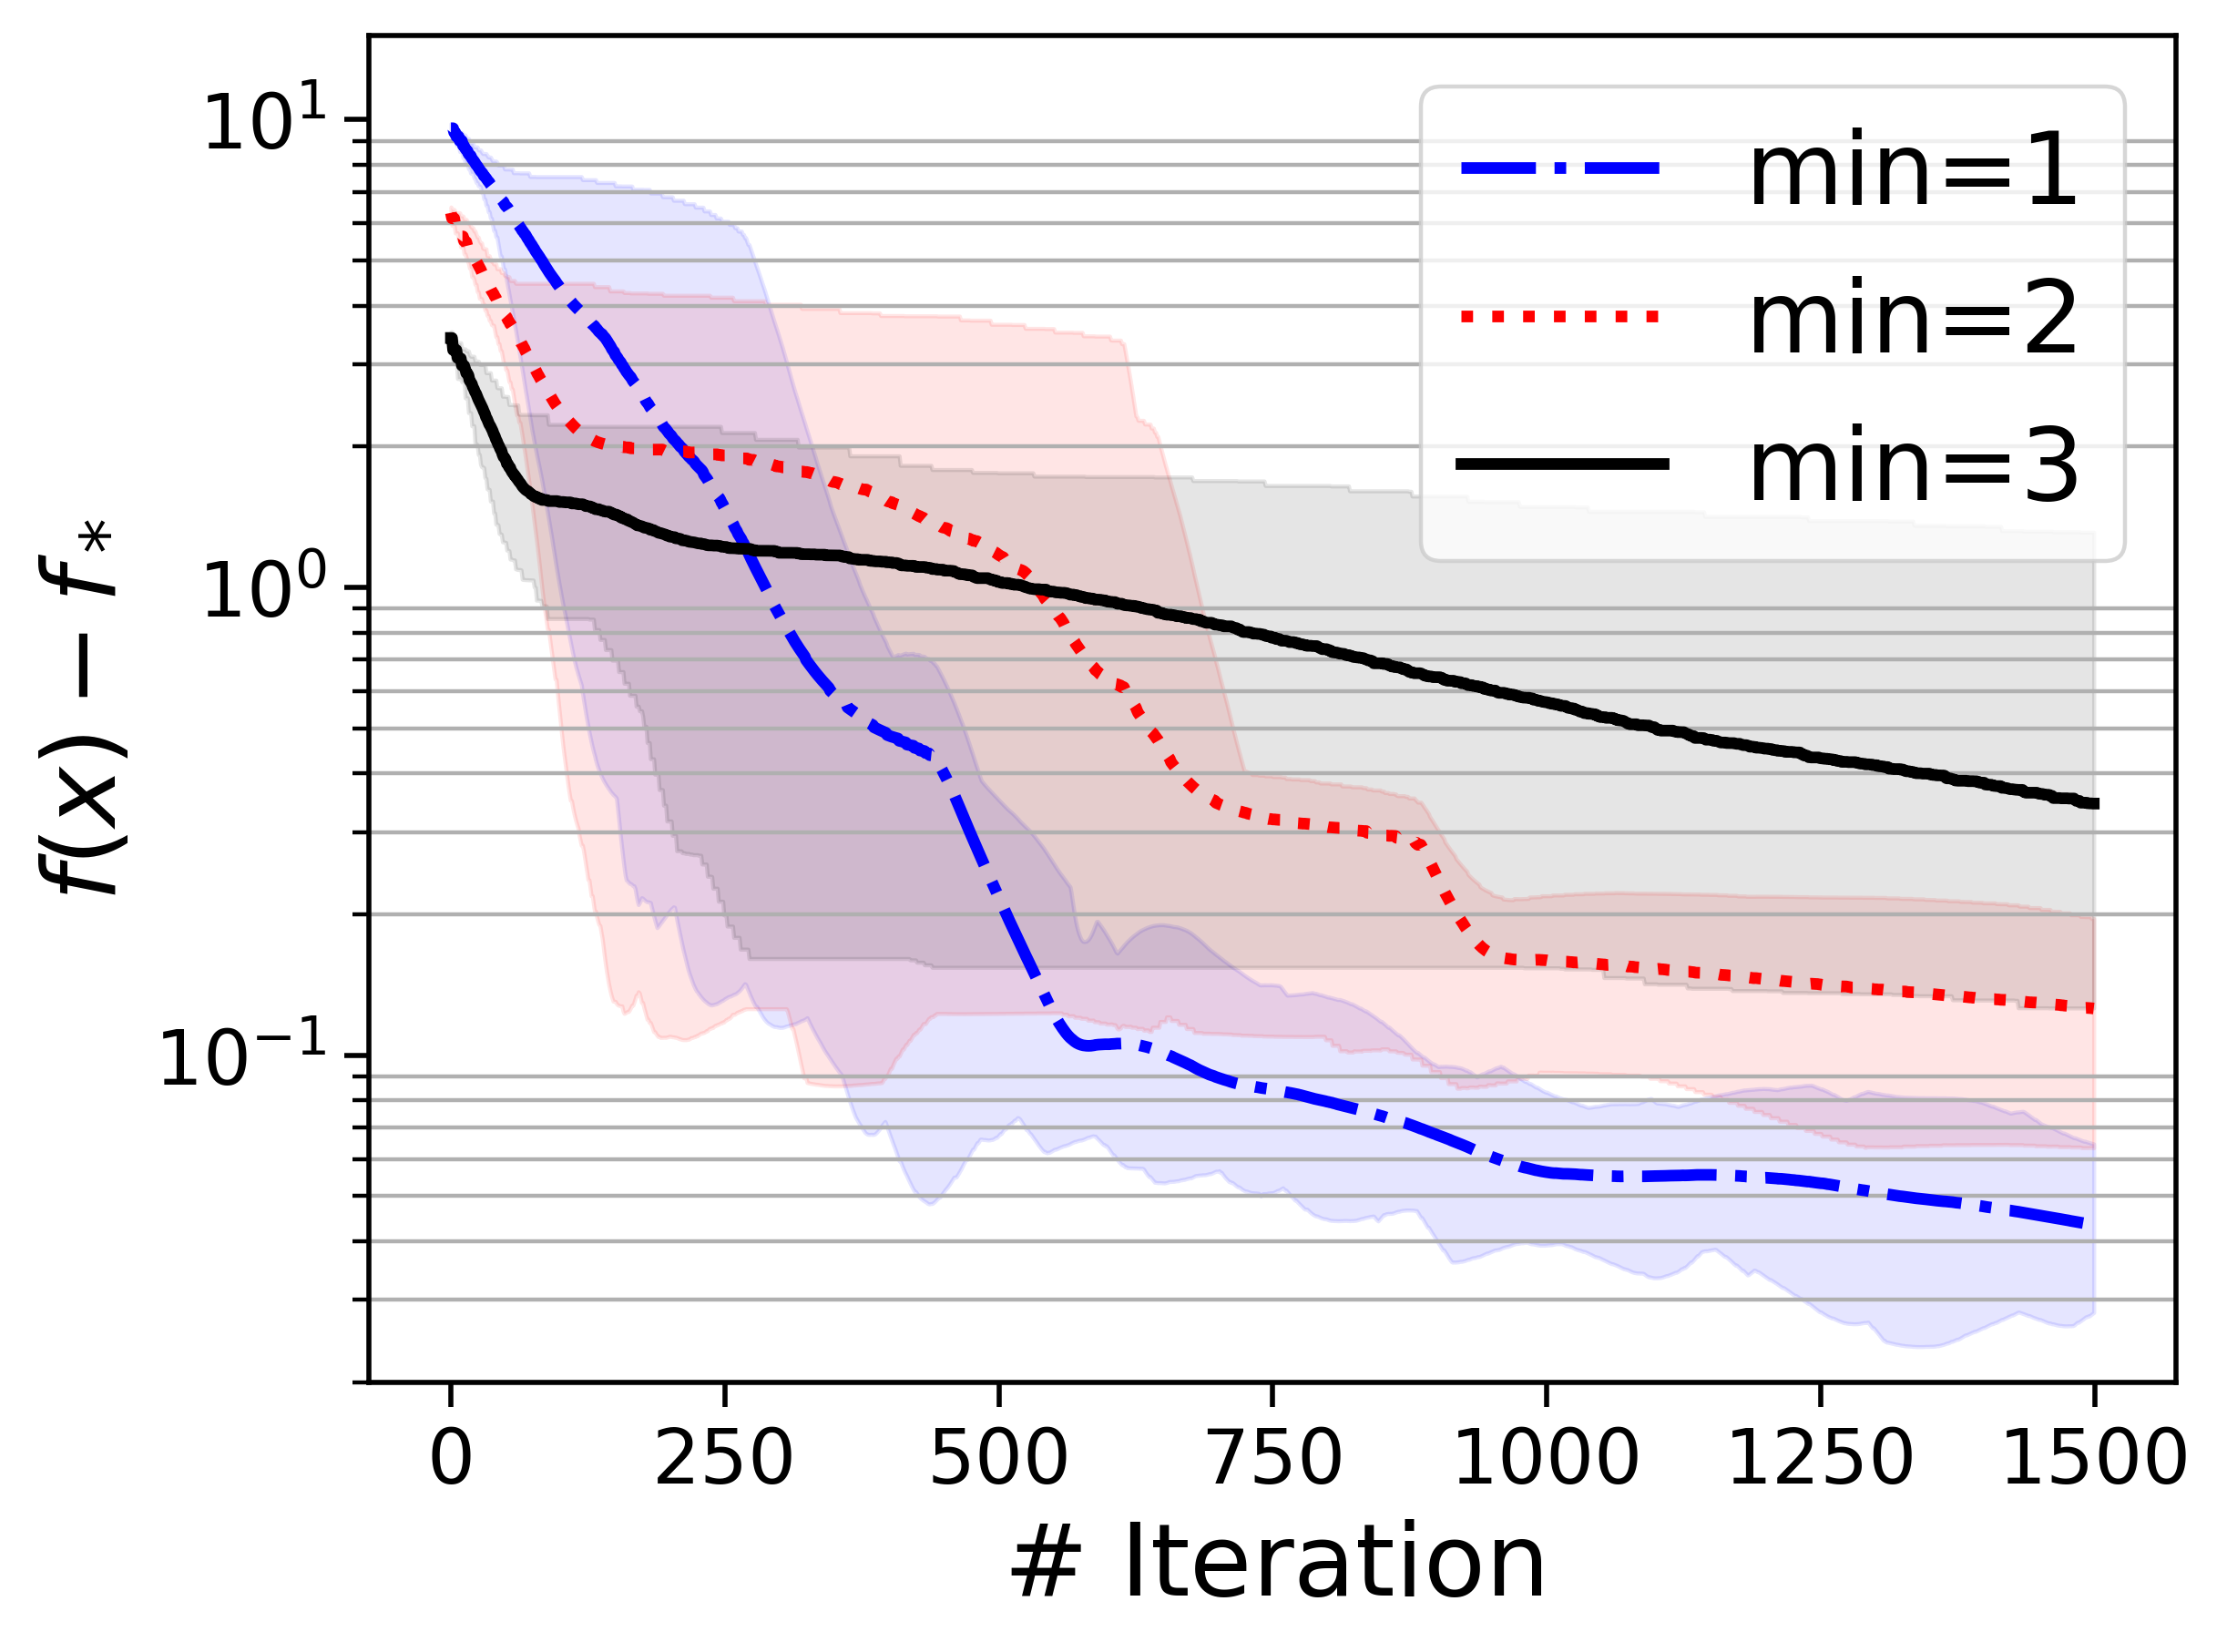

In [69]:

colors = ["b", "r", "black",  "gray", "green"]

figs = {}
figs["running"] = draw_all_steps(results, arms, colors = colors, with_intervals=True)
figs["cumulative"] = draw_cumulative_regret(results, min_val = min(min_vals))
figs["deltas"] = draw_deltas(results, arms, min_vals,colors=colors, ylim=(0.02, 15.1))


In [71]:
import os


savepath = Path("../exp_results/figures")
# exp_results/figures
for f_name, fig in figs.items():
    path = savepath / "stochastic"
    if not path.exists():
        os.mkdir(path)
    f_name = f"{f_name}"
    savefig(fig, path, f_name)

dfdfdf